# Классификация пользователей оператора телекоммуникаций

Заказчик, оператор связи, хочет научиться выявлять клиентов, склонных к уходу в ближайшее время.

Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия.

Заказчиком предоставлены данные о некоторых клиентах, информация об их тарифах и договорах.

Ключевые слова: scipy, pandas, matplotlib, CatBoost, LightGBM, PhiK, Optuna
    
Определение степени вклада факторов: Feature Importance, Univariate Selection, Recursive factor elimination

### Описание услуг

Оператор предоставляет два основных типа услуг: 
* Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
* Интернет. Подключение может быть двух типов: через телефонную линию (DSL) или оптоволоконный кабель (Fiber optic).  

Также доступны услуги:
* Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
* Выделенная линия технической поддержки (TechSupport);
* Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
* Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта, в т.ч. возможность оплаты как бумажным, так и электронным чеком.

### Описание данных

Данные состоят из файлов, полученных из разных источников:
* contract.csv — информация о договоре;
* personal.csv — персональные данные клиента;
* internet.csv — информация об интернет-услугах;
* phone.csv — информация об услугах телефонии.

Во всех файлах столбец customerID содержит код клиента.
Информация о договорах актуальна на 1 февраля 2020.

### Расшифровка некоторых признаков
* BeginDate – дата начала пользования услугами,
* EndDate – дата окончания пользования услугами,
* Type – тип оплаты: ежемесячный, годовой и тд,
* PaperlessBilling – электронный документ об оплате,
* PaymentMethod – способ оплаты,
* MonthlyCharges – ежемесячные траты на услуги,
* TotalCharges – всего потрачено денег на услуги
* Dependents – наличие иждивенцев
* Senior Citizen – наличие пенсионного статуса по возрасту
* Partner – наличие супруга(и)
* MultipleLines – наличие возможности ведения параллельных линий во время звонка

Добавленные факторы:
* hasPhone - клиент использует услуги телефонной связи
* hasInternet - клиент использует услуги Интернета
* hasLeft - клиент ушёл из компании (целевой признак)
* lifeSpan - срок жизни клиента в днях. Рассчитывается до момента ухода клиента или до даты исследуемой выгрузки.

### Критерий успешности проекта
Метрика AUC-ROC ≥ 0.88

### План проекта
* Выполнить загрузку и предварительный анализ данных
* Предобработка и ислледовательский анализ данных
    * Преобразовать данные по типам
    * Обработать искажения
    * Собрать таблицы в единый масив данных
    * Проанализировать баланс целевых классов, если требуется - провести ребалансировку данных
    * Проверить факторы на мультиколлинеарность
* Подготовить данные для обучения модели
    * Удалить факторы, не участвующие в обучении        
    * Провести нормализацию факторов для логистической и иных чувствительных моделей
* Обучить модели с тестированием через кросс-валидацию
* Протестировать модели с наилучшими гиперпараметрами
* Написать общий вывод

## Загрузка и предварительный анализ данных

### 1.1 Общие настройки

In [62]:
!pip install optuna
!pip install phik

In [63]:
# загружаем необходимые библиотеки и определяем пространства имён
import time
import random
#import math

import numpy as np

import scipy.stats as st

import pandas as pd

import seaborn as sns
sns.set(color_codes=True)
sns.set_style('darkgrid')

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
#import matplotlib.ticker as plticker

from functools import reduce
#idx = pd.IndexSlice

# sklearn
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV

from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier


#from sklearn.metrics import get_scorer_names
from sklearn.metrics import make_scorer
#from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

import lightgbm as lgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import optuna

import phik
#from phik.report import plot_correlation_matrix
#from phik import report

#включим отображение всех столбцов таблиц и округлим числа до сотых
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 200
pd.options.display.float_format = '{:,.3f}'.format

# убираем сообщения уровня INFO
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [64]:
#дополнительные условия
RANDOM_STATE = 120922
TEST_SAMPLE_RATIO = .25
DUMP_DATE = pd.to_datetime('2020-02-01')

In [65]:
# универсальная функция описания датасета
def describe_df(df):
    # общий анализ структуры и состава загруженного файла
    df.info()
    
    print("\nЧисло пропусков в данных:", sep='')
    missing_columns = ['missing']
    missing_lines = pd.DataFrame(df.isna().sum(), columns=missing_columns)
    missing_lines['percent'] = missing_lines['missing']/len(df)*100
    display(missing_lines)
    
    print("\nОписательная статистика:")
    display(df.describe(include='all', datetime_is_numeric=True))
    
    print("\nСлучайная выборка:")
    display(df.sample(10))
    
    print('\nПолных дубликатов:', df.duplicated().sum())

In [66]:
# функция загрузки данных с описанием
def load_analyze_file(fileName):
    try:
        df = pd.read_csv('datasets/final_provider/' + fileName) # locally hosted datafile ## , sep='\t'
    except:
        df = pd.read_csv('/datasets/final_provider/' + fileName) # Yandex-hosted datafile  ## , sep='\t'

    describe_df(df)
    
    return df

#print('\nПроверка сбалансированности целевых классов:\n',df['is_ultra'].value_counts())

In [67]:
# функция анализа распределения параметра
def histogram_boxplot(data, xlabel = None, title = None, font_scale=1, figsize=(14,8), bins = None):
    """ Boxplot and histogram combined
    data: 1-d data array
    xlabel: xlabel 
    title: title
    font_scale: the scale of the font (default 2)
    figsize: size of fig (default (9,8))
    bins: number of bins (default None / auto)

    example use: histogram_boxplot(np.random.rand(100), bins = 20, title="Fancy plot")
    """

    sns.set(font_scale=font_scale)
    f2, (ax_box2, ax_hist2) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=figsize)
    sns.boxplot(x=data, ax=ax_box2)
    sns.histplot(x=data, ax=ax_hist2, bins=bins) if bins else sns.histplot(x=data, ax=ax_hist2)
    if xlabel: ax_hist2.set(xlabel=xlabel)
    if title: ax_box2.set(title=title)
    plt.show()

### 1.2 Загрузка данных

In [68]:
df_personal = load_analyze_file('personal.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB

Число пропусков в данных:


,missing,percent
customerID,0,0.000
gender,0,0.000
SeniorCitizen,0,0.000
Partner,0,0.000
Dependents,0,0.000



Описательная статистика:


,customerID,gender,SeniorCitizen,Partner,Dependents
count,7043,7043,"7,043.000",7043,7043
unique,7043,2,NaN,2,2
top,4627-MIHJH,Male,NaN,No,No
freq,1,3555,NaN,3641,4933
mean,NaN,NaN,0.162,NaN,NaN
std,NaN,NaN,0.369,NaN,NaN
min,NaN,NaN,0.000,NaN,NaN
25%,NaN,NaN,0.000,NaN,NaN
50%,NaN,NaN,0.000,NaN,NaN
75%,NaN,NaN,0.000,NaN,NaN



Случайная выборка:


,customerID,gender,SeniorCitizen,Partner,Dependents
5363,3810-PJUHR,Male,0,Yes,Yes
6644,0898-XCGTF,Male,0,Yes,No
515,9412-GHEEC,Male,0,No,No
1767,3669-WHAFY,Female,0,Yes,No
683,7251-LJBQN,Female,1,No,No
1946,7449-HVPIV,Male,0,Yes,Yes
6402,8510-TMWYB,Female,0,Yes,Yes
3794,4280-DLSHD,Male,0,Yes,No
3478,7673-LPRNY,Female,0,No,No
2119,9805-FILKB,Male,0,Yes,Yes



Полных дубликатов: 0


In [69]:
df_contract = load_analyze_file('contract.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB

Число пропусков в данных:


,missing,percent
customerID,0,0.000
BeginDate,0,0.000
EndDate,0,0.000
Type,0,0.000
PaperlessBilling,0,0.000
PaymentMethod,0,0.000
MonthlyCharges,0,0.000
TotalCharges,0,0.000



Описательная статистика:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043,"7,043.000",7043
unique,7043,77,5,3,2,4,NaN,6531
top,4627-MIHJH,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,
freq,1,366,5174,3875,4171,2365,NaN,11
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.762,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,30.090,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.500,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,70.350,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,89.850,NaN



Случайная выборка:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
6823,7009-LGECI,2019-10-01,No,Month-to-month,Yes,Bank transfer (automatic),50.550,235.65
2704,9640-ZSLDC,2015-09-01,No,One year,No,Credit card (automatic),60.600,3297
4242,6124-ACRHJ,2020-01-01,No,Month-to-month,No,Mailed check,19.750,19.75
3681,4433-JCGCG,2016-02-01,2019-12-01 00:00:00,Month-to-month,Yes,Electronic check,101.000,4680.05
1442,3253-HKOKL,2015-10-01,No,One year,No,Electronic check,100.300,5244.45
4285,1506-YJTYT,2016-05-01,No,Two year,No,Credit card (automatic),73.850,3371
1012,7426-RHZGU,2019-05-01,No,Month-to-month,Yes,Bank transfer (automatic),95.900,827.45
6153,6685-XSHHU,2015-02-01,No,Two year,Yes,Bank transfer (automatic),20.950,1270.55
3851,0206-OYVOC,2016-04-01,No,Two year,Yes,Mailed check,19.250,864.2
4812,5174-RNGBH,2019-02-01,2019-11-01 00:00:00,Month-to-month,No,Mailed check,66.250,620.55



Полных дубликатов: 0


Проверим классификаторы на наличие неявных дублей

In [70]:
print(df_contract['PaymentMethod'].value_counts())

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64


In [71]:
print(df_contract['Type'].value_counts())

Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64


Неявных дублей не вявлено.

Графики будут в следующем аналитическом разделе.

In [72]:
df_phone = load_analyze_file('phone.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB

Число пропусков в данных:


,missing,percent
customerID,0,0.000
MultipleLines,0,0.000



Описательная статистика:


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,4627-MIHJH,No
freq,1,3390



Случайная выборка:


,customerID,MultipleLines
3585,5712-VBOXD,No
3729,2190-PHBHR,Yes
3285,2612-RANWT,Yes
4311,8544-JNBOX,No
5551,0623-EJQEG,Yes
3503,8439-LTUGF,No
356,0979-PHULV,Yes
1209,3910-MRQOY,No
3253,4634-JLRJT,No
4265,7036-ZZKBD,No



Полных дубликатов: 0


In [73]:
df_internet = load_analyze_file('internet.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB

Число пропусков в данных:


,missing,percent
customerID,0,0.000
InternetService,0,0.000
OnlineSecurity,0,0.000
OnlineBackup,0,0.000
DeviceProtection,0,0.000
TechSupport,0,0.000
StreamingTV,0,0.000
StreamingMovies,0,0.000



Описательная статистика:


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,4550-EVXNY,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785



Случайная выборка:


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
4096,1981-INRFU,Fiber optic,No,No,No,No,Yes,No
3260,9253-VIFJQ,DSL,Yes,Yes,Yes,No,No,No
3985,7811-JIVPF,DSL,No,No,Yes,No,No,No
178,6341-JVQGF,DSL,Yes,No,Yes,Yes,Yes,Yes
4668,7049-GKVZY,DSL,Yes,Yes,No,Yes,Yes,Yes
4531,8695-ARGXZ,Fiber optic,No,No,No,No,No,No
3974,7269-JISCY,DSL,No,No,No,No,No,No
3381,1101-SSWAG,DSL,No,No,No,No,No,No
3542,2607-FBDFF,DSL,No,No,No,Yes,No,No
4348,7880-XSOJX,DSL,Yes,Yes,No,Yes,No,No



Полных дубликатов: 0


In [74]:
#анализ неявных дублей классификатора
df_internet['InternetService'].value_counts()

Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64

Неявные дубли также не выявлены

## Выводы по шагу 1

<div class="alert alert-block alert-info">
</div>

* Все таблицы успешно загружены, разделители и ключи понятны.
* В данных нет пропусков, при этом число строк в таблицах не совпадает: могут быть расхождения при связке данных по ключу customerID.
* Очевидных искажений и выбросов в данных не наблюдается.
* Полные дубликаты не выявлены. Т.к. данные содержат ключи, предполагается их уникальность. Наличие дублей говорило бы об ошибке выгрузки.
* Дубли категориальных признаков не выявлены. Более подробный их анализ будет проводиться в исследовательской части.
* Часть типов данных автоматически не распознана при загрузке, скорее всего там есть неформатные значения. Необходимо будет проанализировать искажения и преобразовать данные в следующие типы:
    * Таблица *personal*: поле SeniorCitizen уже содержит логическое числовое (0/1) значение
    * Таблица *contract*: поля BeginDate, EndDate приветси к дате, поле TotalCharges привести к float64
    * Все Yes/No перобразовать в к логические числовые (0/1) значения
* После создания сводной таблицы по всем датасетам необходимо проверить появление пропущенных значений и обработать их.
* Целевые классы можно получить из поля contract.EndDate по принципу заполнения/незаполнения даты
* Полезно рассчитать срок жизни клиента по дате начала и дате завершения контракта

## 2. Предобработка и исследовательский анализ данных

### 2.1 Предобработка данных

Не все пользователи используют телефон и интернет. Добавим "технические" признаки перед объединением таблиц

In [75]:
# V1: замена на string, всё равно потом перекодирвоать после объединения
df_phone['hasPhone'] = 'Yes'
df_internet['hasInternet'] = 'Yes'

Преобразуем ключевые данные для проведения анализа и обучения моделей

In [76]:
#Преобразуем типы факторов
df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate'], format='%Y-%m-%d').dt.date.astype('datetime64')

df_contract['EndDate'] = pd.to_datetime(df_contract['EndDate'], format='%Y-%m-%d %H:%M:%S',
                                        errors='coerce').dt.date.astype('datetime64')

df_contract['TotalCharges'] = pd.to_numeric(df_contract['TotalCharges'], errors='coerce')

# целевой класс
df_contract['hasLeft'] = df_contract['EndDate'].notna().astype("int64")

Заполним срок жизни клиента. Если он не покинул компанию, расчёт идёт до дня выгрузки данных.

In [77]:
df_contract_end_date = df_contract['EndDate'].copy()
df_contract_end_date.loc[df_contract_end_date.isna()] = DUMP_DATE
                                                   
df_contract['lifeSpan'] = ((df_contract_end_date - df_contract['BeginDate']) / np.timedelta64(1, 'D')).astype("int64")

Объединим таблицы в одну общую

In [78]:
dataframes = [df_personal, df_contract, df_phone, df_internet]
df_grouped = reduce(lambda left,right: pd.merge(left,right,on=['customerID'], how='outer'), dataframes)
df_grouped.info()
display(df_grouped.head(10))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   gender            7043 non-null   object        
 2   SeniorCitizen     7043 non-null   int64         
 3   Partner           7043 non-null   object        
 4   Dependents        7043 non-null   object        
 5   BeginDate         7043 non-null   datetime64[ns]
 6   EndDate           1869 non-null   datetime64[ns]
 7   Type              7043 non-null   object        
 8   PaperlessBilling  7043 non-null   object        
 9   PaymentMethod     7043 non-null   object        
 10  MonthlyCharges    7043 non-null   float64       
 11  TotalCharges      7032 non-null   float64       
 12  hasLeft           7043 non-null   int64         
 13  lifeSpan          7043 non-null   int64         
 14  MultipleLines     6361 n

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,hasLeft,lifeSpan,MultipleLines,hasPhone,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,hasInternet
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.850,29.850,0,31,NaN,NaN,DSL,No,Yes,No,No,No,No,Yes
1,5575-GNVDE,Male,0,No,No,2017-04-01,NaT,One year,No,Mailed check,56.950,"1,889.500",0,1036,No,Yes,DSL,Yes,No,Yes,No,No,No,Yes
2,3668-QPYBK,Male,0,No,No,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.850,108.150,1,61,No,Yes,DSL,Yes,Yes,No,No,No,No,Yes
3,7795-CFOCW,Male,0,No,No,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.300,"1,840.750",0,1371,NaN,NaN,DSL,Yes,No,Yes,Yes,No,No,Yes
4,9237-HQITU,Female,0,No,No,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.700,151.650,1,61,No,Yes,Fiber optic,No,No,No,No,No,No,Yes
5,9305-CDSKC,Female,0,No,No,2019-03-01,2019-11-01,Month-to-month,Yes,Electronic check,99.650,820.500,1,245,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
6,1452-KIOVK,Male,0,No,Yes,2018-04-01,NaT,Month-to-month,Yes,Credit card (automatic),89.100,"1,949.400",0,671,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes
7,6713-OKOMC,Female,0,No,No,2019-04-01,NaT,Month-to-month,No,Mailed check,29.750,301.900,0,306,NaN,NaN,DSL,Yes,No,No,No,No,No,Yes
8,7892-POOKP,Female,0,Yes,No,2017-07-01,2019-11-01,Month-to-month,Yes,Electronic check,104.800,"3,046.050",1,853,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes
9,6388-TABGU,Male,0,No,Yes,2014-12-01,NaT,One year,No,Bank transfer (automatic),56.150,"3,487.950",0,1888,No,Yes,DSL,Yes,Yes,No,No,No,No,Yes


Преобразуем все колонки с булевым значением в двоичное 0/1

In [79]:
columns = [
    'SeniorCitizen', 'Partner', 'Dependents', 
    'PaperlessBilling',
    'MultipleLines',
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
    # V1: добавил два дополнительных параметра в общий трек перекодирования
    'hasPhone','hasInternet'
]

# нет смысла отслеживать пропуски -- эти сервисы человек не использовал
df_grouped[columns] = df_grouped[columns].fillna(0)

df_grouped[columns] = df_grouped[columns].replace({'Yes': 1, 'No': 0}).astype('int64')

Дозаполним неопределённые значения факторов, возникшие в связи с объединением таблицы.

In [81]:
# пользователям, не использующим Интернет-услуги, ставим новый тип 'None'
df_grouped['InternetService'] = df_grouped['InternetService'].fillna('None')

Пользователи, не использующие ни один из предоставляемых видов услуг, в датасете отсутсвуют.

In [ ]:
display(df_grouped.query('hasPhone == 0 & hasInternet == 0'))

Выборочно проверим корректность объединения таблиц и заполнения факторов

In [82]:
def dislpay_customer_data(customer_id):
    print('\nCustomer', customer_id)
    display(df_personal.query(f"customerID == '{customer_id}'"))
    display(df_contract.query(f"customerID == '{customer_id}'"))
    display(df_phone.query(f"customerID == '{customer_id}'"))
    display(df_internet.query(f"customerID == '{customer_id}'"))
    display(df_grouped.query(f"customerID == '{customer_id}'"))
    
dislpay_customer_data('5245-VDBUR')
dislpay_customer_data('8361-LTMKD')

#df_grouped.query('hasLeft ==1 & hasPhone == 1 & hasInternet == 1')


Customer 5245-VDBUR


,customerID,gender,SeniorCitizen,Partner,Dependents
6747,5245-VDBUR,Female,0,Yes,No


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,hasLeft,lifeSpan
6747,5245-VDBUR,2015-10-01,NaT,One year,No,Mailed check,35.450,"1,958.950",0,1584


,customerID,MultipleLines,hasPhone


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,hasInternet
5272,5245-VDBUR,DSL,Yes,No,Yes,No,No,No,Yes


,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,hasLeft,lifeSpan,MultipleLines,hasPhone,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,hasInternet
6747,5245-VDBUR,Female,0,1,0,2015-10-01,NaT,One year,0,Mailed check,35.450,"1,958.950",0,1584,0,0,DSL,1,0,1,0,0,0,1



Customer 8361-LTMKD


,customerID,gender,SeniorCitizen,Partner,Dependents
7041,8361-LTMKD,Male,1,Yes,No


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,hasLeft,lifeSpan
7041,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,Yes,Mailed check,74.400,306.600,1,123


,customerID,MultipleLines,hasPhone
6359,8361-LTMKD,Yes,Yes


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,hasInternet
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No,Yes


,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,hasLeft,lifeSpan,MultipleLines,hasPhone,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,hasInternet
7041,8361-LTMKD,Male,1,1,0,2019-07-01,2019-11-01,Month-to-month,1,Mailed check,74.400,306.600,1,123,1,1,Fiber optic,0,0,0,0,0,0,1


In [83]:
describe_df(df_grouped)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   gender            7043 non-null   object        
 2   SeniorCitizen     7043 non-null   int64         
 3   Partner           7043 non-null   int64         
 4   Dependents        7043 non-null   int64         
 5   BeginDate         7043 non-null   datetime64[ns]
 6   EndDate           1869 non-null   datetime64[ns]
 7   Type              7043 non-null   object        
 8   PaperlessBilling  7043 non-null   int64         
 9   PaymentMethod     7043 non-null   object        
 10  MonthlyCharges    7043 non-null   float64       
 11  TotalCharges      7032 non-null   float64       
 12  hasLeft           7043 non-null   int64         
 13  lifeSpan          7043 non-null   int64         
 14  MultipleLines     7043 n

,missing,percent
customerID,0,0.000
gender,0,0.000
SeniorCitizen,0,0.000
Partner,0,0.000
Dependents,0,0.000
BeginDate,0,0.000
EndDate,5174,73.463
Type,0,0.000
PaperlessBilling,0,0.000
PaymentMethod,0,0.000



Описательная статистика:


,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,hasLeft,lifeSpan,MultipleLines,hasPhone,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,hasInternet
count,7043,7043,"7,043.000","7,043.000","7,043.000",7043,1869,7043,"7,043.000",7043,"7,043.000","7,032.000","7,043.000","7,043.000","7,043.000","7,043.000",7043,"7,043.000","7,043.000","7,043.000","7,043.000","7,043.000","7,043.000","7,043.000"
unique,7043,2,NaN,NaN,NaN,NaN,NaN,3,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,4627-MIHJH,Male,NaN,NaN,NaN,NaN,NaN,Month-to-month,NaN,Electronic check,NaN,NaN,NaN,NaN,NaN,NaN,Fiber optic,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,3555,NaN,NaN,NaN,NaN,NaN,3875,NaN,2365,NaN,NaN,NaN,NaN,NaN,NaN,3096,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,0.162,0.483,0.300,2017-04-30 13:01:50.918642688,2019-11-15 21:31:18.009630976,NaN,0.592,NaN,64.762,"2,283.300",0.265,985.996,0.422,0.903,NaN,0.287,0.345,0.344,0.290,0.384,0.388,0.783
min,NaN,NaN,0.000,0.000,0.000,2013-10-01 00:00:00,2019-10-01 00:00:00,NaN,0.000,NaN,18.250,18.800,0.000,0.000,0.000,0.000,NaN,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,NaN,NaN,0.000,0.000,0.000,2015-06-01 00:00:00,2019-11-01 00:00:00,NaN,0.000,NaN,35.500,401.450,0.000,273.000,0.000,1.000,NaN,0.000,0.000,0.000,0.000,0.000,0.000,1.000
50%,NaN,NaN,0.000,0.000,0.000,2017-09-01 00:00:00,2019-11-01 00:00:00,NaN,1.000,NaN,70.350,"1,397.475",0.000,883.000,0.000,1.000,NaN,0.000,0.000,0.000,0.000,0.000,0.000,1.000
75%,NaN,NaN,0.000,1.000,1.000,2019-04-01 00:00:00,2019-12-01 00:00:00,NaN,1.000,NaN,89.850,"3,794.738",1.000,"1,676.000",1.000,1.000,NaN,1.000,1.000,1.000,1.000,1.000,1.000,1.000
max,NaN,NaN,1.000,1.000,1.000,2020-02-01 00:00:00,2020-01-01 00:00:00,NaN,1.000,NaN,118.750,"8,684.800",1.000,"2,191.000",1.000,1.000,NaN,1.000,1.000,1.000,1.000,1.000,1.000,1.000



Случайная выборка:


,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,hasLeft,lifeSpan,MultipleLines,hasPhone,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,hasInternet
6372,6368-TZZDT,Male,0,1,1,2019-10-01,NaT,Two year,0,Credit card (automatic),19.500,96.850,0,123,0,1,None,0,0,0,0,0,0,0
6387,9853-JFZDU,Female,0,1,0,2017-03-01,NaT,Month-to-month,0,Electronic check,56.850,"1,861.100",0,1067,0,1,DSL,0,1,0,1,0,0,1
6127,6198-PNNSZ,Female,0,1,0,2015-06-01,NaT,One year,0,Bank transfer (automatic),109.800,"6,109.650",0,1706,1,1,Fiber optic,1,1,1,0,1,1,1
2826,3638-DIMPH,Female,0,1,0,2019-01-01,NaT,One year,0,Electronic check,43.800,592.650,0,396,0,1,DSL,0,0,0,0,0,0,1
7013,1685-BQULA,Female,0,0,0,2016-10-01,NaT,Month-to-month,1,Bank transfer (automatic),93.400,"3,756.400",0,1218,1,1,Fiber optic,0,1,1,0,1,0,1
4248,1020-JPQOW,Female,0,1,0,2015-06-01,NaT,Month-to-month,0,Electronic check,90.550,"5,116.600",0,1706,1,1,Fiber optic,0,1,1,1,0,0,1
3415,1625-JAIIY,Female,0,1,1,2014-04-01,2019-12-01,One year,1,Electronic check,83.000,"5,685.800",1,2070,1,1,Fiber optic,0,0,0,0,1,0,1
498,6235-VDHOM,Female,1,0,0,2019-07-01,2019-12-01,Month-to-month,0,Electronic check,28.450,131.050,1,153,0,0,DSL,0,1,0,0,0,0,1
5486,7609-YBPXG,Male,0,0,0,2015-08-01,NaT,Two year,0,Bank transfer (automatic),87.100,"4,735.200",0,1645,1,1,DSL,1,0,1,1,1,1,1
2607,5539-TMZLF,Male,1,0,0,2019-12-01,2020-01-01,Month-to-month,1,Electronic check,69.750,69.750,1,31,0,1,Fiber optic,0,0,0,0,0,0,1



Полных дубликатов: 0


In [84]:
# Клиенты с пропуском в общей сумме затрат. Так как дата регистрации равна дате выгрузки, возможно, их затраты ещё не загружены из системы биллинга.
# поставим 0
display(df_grouped.loc[df_grouped['TotalCharges'].isna()])

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,hasLeft,lifeSpan,MultipleLines,hasPhone,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,hasInternet
488,4472-LVYGI,Female,0,1,1,2020-02-01,NaT,Two year,1,Bank transfer (automatic),52.550,NaN,0,0,0,0,DSL,1,0,1,1,1,0,1
753,3115-CZMZD,Male,0,0,1,2020-02-01,NaT,Two year,0,Mailed check,20.250,NaN,0,0,0,1,None,0,0,0,0,0,0,0
936,5709-LVOEQ,Female,0,1,1,2020-02-01,NaT,Two year,0,Mailed check,80.850,NaN,0,0,0,1,DSL,1,1,1,0,1,1,1
1082,4367-NUYAO,Male,0,1,1,2020-02-01,NaT,Two year,0,Mailed check,25.750,NaN,0,0,1,1,None,0,0,0,0,0,0,0
1340,1371-DWPAZ,Female,0,1,1,2020-02-01,NaT,Two year,0,Credit card (automatic),56.050,NaN,0,0,0,0,DSL,1,1,1,1,1,0,1
3331,7644-OMVMY,Male,0,1,1,2020-02-01,NaT,Two year,0,Mailed check,19.850,NaN,0,0,0,1,None,0,0,0,0,0,0,0
3826,3213-VVOLG,Male,0,1,1,2020-02-01,NaT,Two year,0,Mailed check,25.350,NaN,0,0,1,1,None,0,0,0,0,0,0,0
4380,2520-SGTTA,Female,0,1,1,2020-02-01,NaT,Two year,0,Mailed check,20.000,NaN,0,0,0,1,None,0,0,0,0,0,0,0
5218,2923-ARZLG,Male,0,1,1,2020-02-01,NaT,One year,1,Mailed check,19.700,NaN,0,0,0,1,None,0,0,0,0,0,0,0
6670,4075-WKNIU,Female,0,1,1,2020-02-01,NaT,Two year,0,Mailed check,73.350,NaN,0,0,1,1,DSL,0,1,1,1,1,0,1


In [85]:
display(df_grouped.loc[df_grouped['BeginDate'] == DUMP_DATE])

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,hasLeft,lifeSpan,MultipleLines,hasPhone,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,hasInternet
488,4472-LVYGI,Female,0,1,1,2020-02-01,NaT,Two year,1,Bank transfer (automatic),52.550,NaN,0,0,0,0,DSL,1,0,1,1,1,0,1
753,3115-CZMZD,Male,0,0,1,2020-02-01,NaT,Two year,0,Mailed check,20.250,NaN,0,0,0,1,None,0,0,0,0,0,0,0
936,5709-LVOEQ,Female,0,1,1,2020-02-01,NaT,Two year,0,Mailed check,80.850,NaN,0,0,0,1,DSL,1,1,1,0,1,1,1
1082,4367-NUYAO,Male,0,1,1,2020-02-01,NaT,Two year,0,Mailed check,25.750,NaN,0,0,1,1,None,0,0,0,0,0,0,0
1340,1371-DWPAZ,Female,0,1,1,2020-02-01,NaT,Two year,0,Credit card (automatic),56.050,NaN,0,0,0,0,DSL,1,1,1,1,1,0,1
3331,7644-OMVMY,Male,0,1,1,2020-02-01,NaT,Two year,0,Mailed check,19.850,NaN,0,0,0,1,None,0,0,0,0,0,0,0
3826,3213-VVOLG,Male,0,1,1,2020-02-01,NaT,Two year,0,Mailed check,25.350,NaN,0,0,1,1,None,0,0,0,0,0,0,0
4380,2520-SGTTA,Female,0,1,1,2020-02-01,NaT,Two year,0,Mailed check,20.000,NaN,0,0,0,1,None,0,0,0,0,0,0,0
5218,2923-ARZLG,Male,0,1,1,2020-02-01,NaT,One year,1,Mailed check,19.700,NaN,0,0,0,1,None,0,0,0,0,0,0,0
6670,4075-WKNIU,Female,0,1,1,2020-02-01,NaT,Two year,0,Mailed check,73.350,NaN,0,0,1,1,DSL,0,1,1,1,1,0,1


Все пользователи с нулевой суммой затрат зарегистрировались в день выгрузки данных. 
Скорее всего их затраты ещё не зафиксированы биллинговой системой. Установим значение затрат в 0.

In [86]:
df_grouped.loc[df_grouped['TotalCharges'].isna(),'TotalCharges'] = 0
display(df_grouped.loc[df_grouped['TotalCharges'].isna()])

# а могли бы и удалить
#df_grouped.info()
#df_grouped = df_grouped.drop(df_grouped[df_grouped['TotalCharges'].isna()].index).reset_index(drop=True)
#df_grouped.info()

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,hasLeft,lifeSpan,MultipleLines,hasPhone,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,hasInternet


### 2.2 Проверка сбалансированности целевых классов

Проверим баланс классов

0   0.735
1   0.265
Name: hasLeft, dtype: float64


<AxesSubplot:>

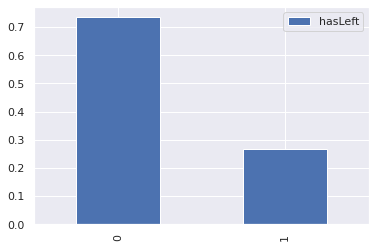

In [87]:
class_balance = df_grouped['hasLeft'].value_counts(normalize=True)
print(class_balance)

names = ['Остаются в компании', 'Покинули компанию']
class_balance.plot(kind='bar', legend=True)
#plot.legend(handles=)

Баланс классов смещён в соотношении примерно 70-30%.
С учётом того, что это реальные данные и уходящих клиентов должно быть по определению меньше, чем остающихся, сначала стоит попробовать оптимизации моделей без ребаланса: через исключение связанных между собой факторов и подбор гиперпараметров.

### 2.3 Исследовательский анализ данных

In [88]:
def print_value_distribution(feature, position, axes_=None):
    if (axes_ is None):        
        axes_pos = None
    else:
        axes_pos = axes_[position]
    
    class_balance = df_grouped[feature].value_counts(normalize=False)    
    class_balance.plot(kind='bar', title=feature, ax=axes_pos, color='C1')
    
    class_balance_left = df_grouped[df_grouped['hasLeft'] == 1][feature].value_counts(normalize=False)
    class_balance_left.plot(kind='bar', title=feature, ax=axes_pos, color='C0')

In [89]:
# input: figure or axe
def print_legend(figure_, left_side=True):
    patch_all = mpatches.Patch(color='C1', label='Все пользователи')
    patch_left = mpatches.Patch(color='C0', label='Ушедшие')
    
    #figure_.legend(handles=[patch_all, patch_left], bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=2)

    if left_side:
        figure_.legend(handles=[patch_all, patch_left], loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        figure_.legend(handles=[patch_all, patch_left], loc='upper center', bbox_to_anchor=(0.5, -0.05),
                       fancybox=True, ncol=2) #, shadow=True,
    

In [90]:
# расширенная функция анализа распределения параметра
def histogram_boxplot_dual(table_, column_, xlabel = None, title = None, font_scale=1, figsize=(14,8), bins = None):
    """ Boxplot and histogram combined
    data: 1-d data array
    xlabel: xlabel 
    title: title
    font_scale: the scale of the font (default 2)
    figsize: size of fig (default (9,8))
    bins: number of bins (default None / auto)

    example use: histogram_boxplot(np.random.rand(100), bins = 20, title="Fancy plot")
    """
    data = table_[column_]
    data_left = table_[table_['hasLeft'] == 1][column_]

    sns.set(font_scale=font_scale)
    f2, (ax_box1, ax_box2, ax_hist2) = plt.subplots(3, sharex=True, gridspec_kw={"height_ratios": (.10, .10, .80)}, figsize=figsize)
    sns.boxplot(x=data, ax=ax_box1, color='C1')
    sns.boxplot(x=data_left, ax=ax_box2, color='C0')
    sns.histplot(x=data, ax=ax_hist2, bins=bins, color='C1') if bins else sns.histplot(x=data, ax=ax_hist2, color='C1')
    sns.histplot(x=data_left, ax=ax_hist2, bins=bins, color='C0') if bins else sns.histplot(x=data, ax=ax_hist2, color='C0')
    if xlabel: ax_hist2.set(xlabel=xlabel)
    if title: ax_box1.set(title=title)
    
    print_legend(f2, False)
    plt.show()

Проверим балансы признаков

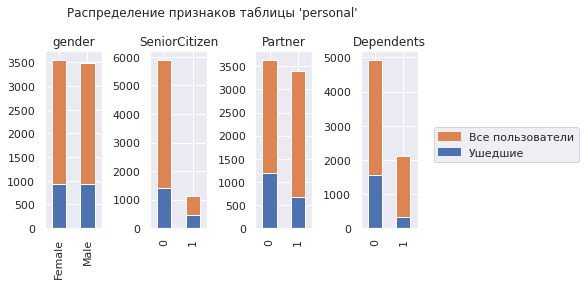

In [91]:
fig, axes = plt.subplots(nrows=1, ncols=4)

print_value_distribution('gender', 0, axes)
print_value_distribution('SeniorCitizen', 1, axes)
print_value_distribution('Partner', 2, axes)
print_value_distribution('Dependents', 3, axes)


plt.suptitle("Распределение признаков таблицы 'personal'")
plt.tight_layout()

print_legend(fig)
plt.show()

Мужчин и женщин в выборке примерно поровну, та же ситуация с людьми одинокими и имеющими партнёра.
Треть клиентов имеет иждивенцев, примерно 18% пользователей - пенсионеры.

* Ушедших мужчин и женщин поровну, данный фактор можно не использовать в модели.
* Пенсионеры уходят чаще, но их немного.
* Люди, не имеющие пратнёра, уходят чаще.
* Люди, не имеющие иждивенцев, уходят чаще.

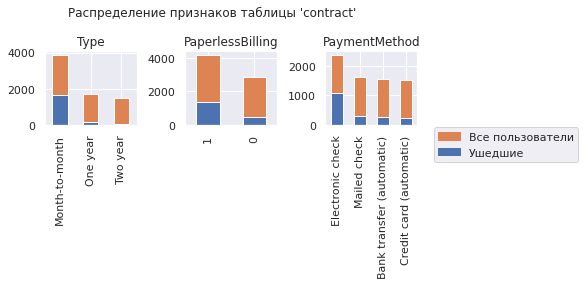

In [92]:
fig, axes = plt.subplots(nrows=1, ncols=3)

print_value_distribution('Type', 0, axes)
print_value_distribution('PaperlessBilling', 1, axes)
print_value_distribution('PaymentMethod', 2, axes)

plt.suptitle("Распределение признаков таблицы 'contract'")
plt.tight_layout()

print_legend(fig)
plt.show()

Чуть более половины пользователей предпочитает ежемесячную оплату, остальные поровну делятся на покупателей двухлетних и трёхлетних тарифных планов.
* При этом половина пользователей с помесячной оплатой ушла. Это выглядит как одна из "категорий риска" ухода.

60% клиентов используют элеткронные счета.
* Клиентов с бумажными счетами ушло примерно в два раза меньше.

22% клиентов платят физическими чеками. Остальные предпочитают электронные средства платежа.
* Примерно половина из плательщиков электронным чеком ушла. Это выглядит как одна из "категорий риска" ухода.

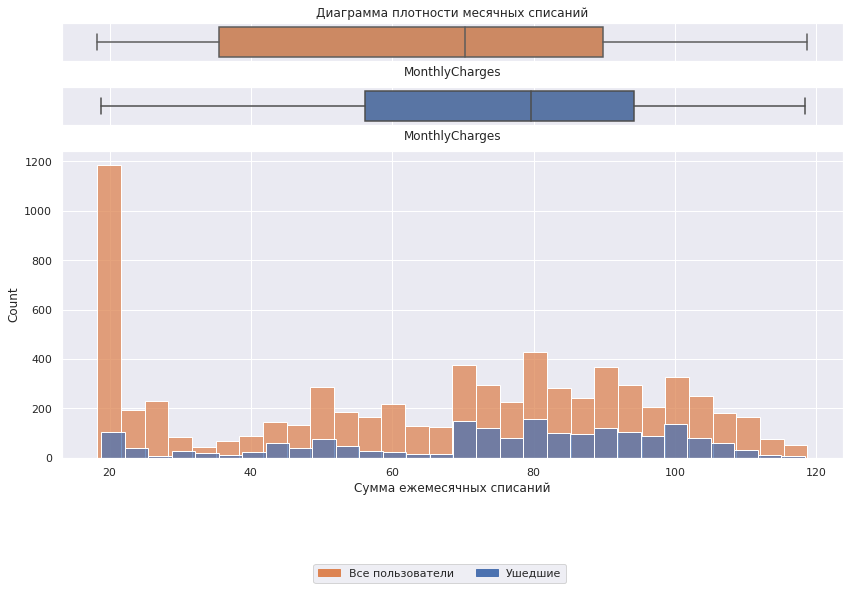

In [93]:
histogram_boxplot_dual(df_grouped, 'MonthlyCharges', bins = 30, title=f'Диаграмма плотности месячных списаний', xlabel="Сумма ежемесячных списаний")

В ежемесячных списаниях наблюдается существенный процент малых платежей (в пределах $20).

Также есть пики на 50, 60, 70, 80, 90 и 100 долларах. Вероятно, они увязаны с тарифными планами или пакетными предложениями.

* Уходят преимущественно клиенты с высоким ежемесячным чеком (от \$70), порядка трети от клиентов с высоким чеком.
* Средний месячный чек ушедших выше примерно на \$10
* Клиенты с высоким чеком уходят чаще, если смотреть в пропорции по сумме. И их явно выгодней удерживать и привлекать акциями.
* С низкими тарифами у провайдера всё выглядит нормально.

Дальнейшим развитием анализа может быть сплит на уровне \$70, потому что это похоже минимум на два разных сегмента клиентов.
Или кластеризация без учителя: посмотреть, в какие группы модель распределит клиентов.

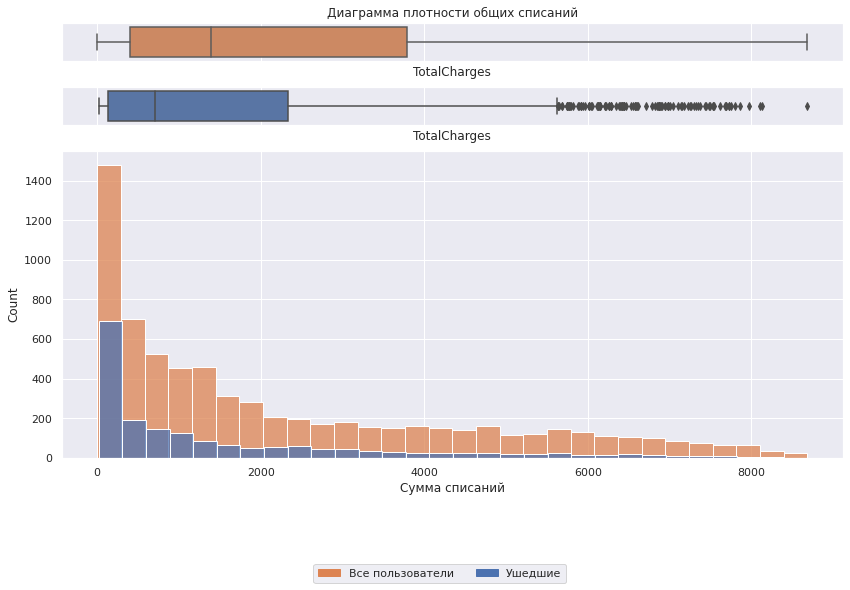

In [94]:
histogram_boxplot_dual(df_grouped, 'TotalCharges', bins = 30, title=f'Диаграмма плотности общих списаний', xlabel="Сумма списаний")

Сумма общих затрат клиентов выглядит закономерно для накапливающегося значения.

* что касается ушедких клиентов - они тратят более чем в два раза меньше денег по сравнению с обычными. По графику можно предположить, что  это относительно новые клиенты, использующие много услуг и неприятно удивляющиеся счетам или недовольные качеством.
* Свыше \$5600 начинаются редкие значения уходов: долгосрочные клиенты остаются верны компании.

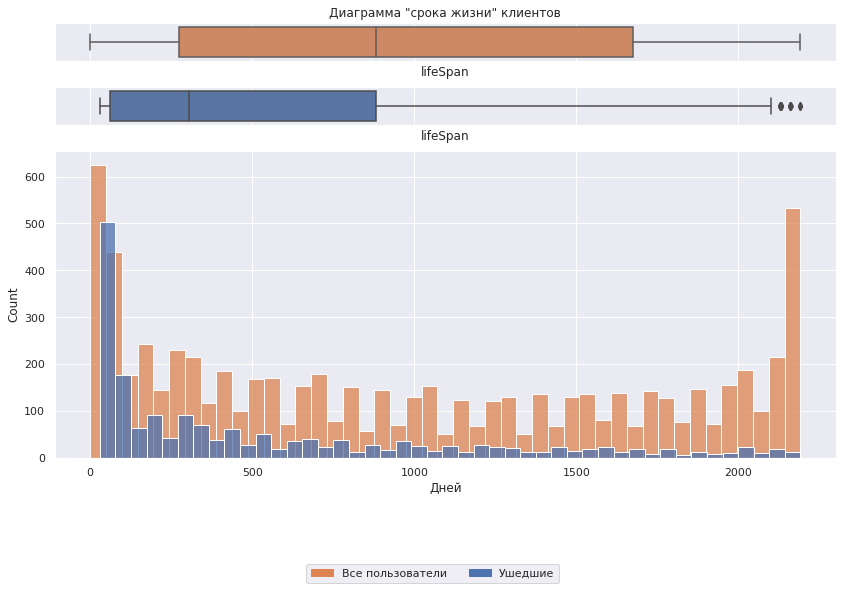

In [95]:
histogram_boxplot_dual(df_grouped, 'lifeSpan', bins = 45, title=f'Диаграмма "срока жизни" клиентов', xlabel="Дней")

* Данный график подтверждает ситуацию: много клиентов уходит сразу.
* В среднем, половина ушедших клиентов разорвала контракт через год.
* Ещё четверть клиентов ушла в срок от года до трёх лет.

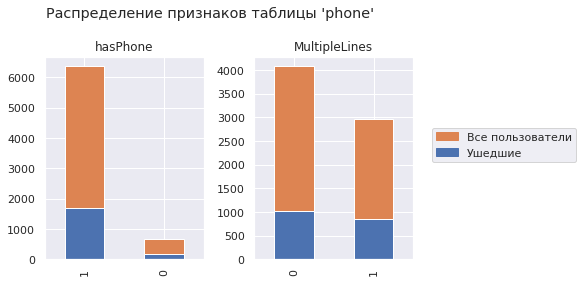

In [96]:
fig, axes = plt.subplots(nrows=1, ncols=2)

print_value_distribution('hasPhone', 0, axes)

print_value_distribution('MultipleLines', 1, axes)

plt.suptitle("Распределение признаков таблицы 'phone'")
plt.tight_layout()

print_legend(fig)
plt.show()

Телефон есть у большинства клиентов. Скорее всего потому, что оператор начинал с телефонии и DSL-интернета.

Пользователи одной и нескольких телефонных линий делятся примерно поровну, ушедшие - тоже. Данный признак, сокрее всего, не будет полезен в модели.

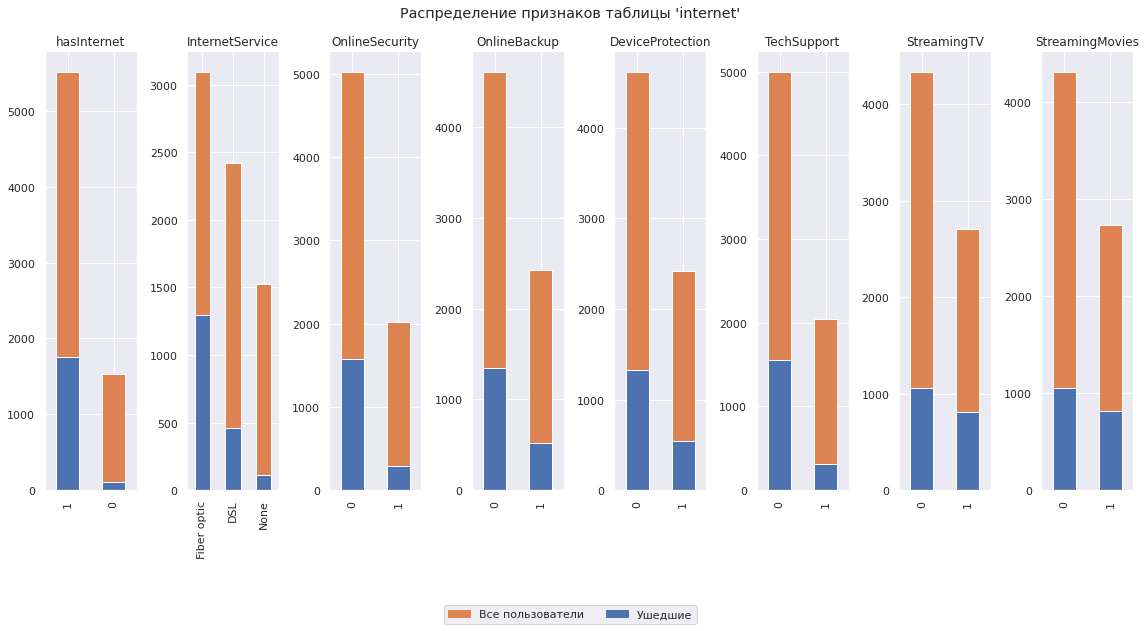

In [97]:
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(16,8))

print_value_distribution('hasInternet', 0, axes)
print_value_distribution('InternetService', 1, axes)
print_value_distribution('OnlineSecurity', 2, axes)
print_value_distribution('OnlineBackup', 3, axes)
print_value_distribution('DeviceProtection', 4, axes)
print_value_distribution('TechSupport', 5, axes)
print_value_distribution('StreamingTV', 6, axes)
print_value_distribution('StreamingMovies', 7, axes)

plt.suptitle("Распределение признаков таблицы 'internet'")
plt.tight_layout()

print_legend(fig, False)
plt.show()

* Чаще уходят пользователи, имеющие интернет.
* Ушедшие пользователи чаще использовали оптическое подключение.
* Ушедшие чаще используют OnlineSecurity.
* Показатели резервного копирования и защиты устройств примерно одинаковы для ушедших и неушедших.
* Ушедшие чаще обращались в (расширенную?) техническую поддержку.
* Ушедшие чаще заказывали услуги просмотра телевидения или кинофильмов, при этом такие услуги интересны менее чем половине клиентов.
* Показатели StreamingTV и StreamingMovies выглядят идентично и сильно (0.74) коррелируют между собой. Скорее всего это пакетное предложение, и один из факторов можно безопасно удалить из модели.
* Так же идентично выглядят пары OnlineSecurity-TechSupport и OnlineBackup-DeviceProtection.

Текущие графики не отвечают на вопрос: а на что же ушедшие тратили свои повышенные чеки? На ТВ и кино, или более скоростные тарифы?

### 2.4 Проверка вклада и взаимозависимостей факторов

Удалим более не требующиеся колонки

In [98]:
df = df_grouped.drop([
    'customerID','BeginDate','EndDate'
], axis=1)

Сохраним перечень оригинальных факторов

In [99]:
column_names = df.columns

Проведём кодирование категориальных факторов с помощью рангового кодирования и проведём его анализ

One-Hot-кодирование будет проведено ниже по финальному перечню факторов, выбранных для модели

In [100]:
factors_to_encode = ['gender', 'Type', 'PaymentMethod', 'InternetService'] #'gender',

In [101]:
# порядковое кодирование
df_oe_full = df.copy()

encoder = OrdinalEncoder()
df_oe_full[factors_to_encode] = encoder.fit_transform(df_oe_full[factors_to_encode]).astype('int64')
display(df_oe_full.sample(10))

column_names_oe_full = df_oe_full.columns

,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,hasLeft,lifeSpan,MultipleLines,hasPhone,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,hasInternet
5757,0,1,1,0,0,0,3,25.700,734.600,0,853,1,1,2,0,0,0,0,0,0,0
277,1,1,1,0,0,1,0,64.950,"1,339.800",0,641,0,1,0,1,1,0,0,0,1,1
1235,1,1,1,0,1,1,3,98.300,"6,066.550",0,1857,1,1,1,0,1,1,1,1,0,1
2204,1,0,1,1,1,1,2,111.300,"7,482.100",1,2040,1,1,1,1,1,1,0,1,1,1
4444,0,0,0,0,0,0,3,19.850,63.750,1,92,0,1,2,0,0,0,0,0,0,0
3491,1,0,1,0,1,1,2,70.950,"3,250.450",0,1340,0,1,0,0,1,1,1,1,0,1
6404,1,0,0,0,2,1,2,109.300,"5,731.400",0,1584,1,1,1,1,0,1,1,1,1,1
2877,0,0,1,1,0,1,2,99.150,"6,010.050",1,1856,1,1,1,0,1,0,0,1,1,1
3227,1,0,1,1,0,1,3,56.300,628.650,0,365,0,1,0,0,0,0,0,1,0,1
6685,0,0,1,0,0,1,1,50.250,"2,221.550",0,1371,0,1,0,0,0,1,0,0,0,1


Вычислим коэффициент корреляции PhiK и выведем матрицу корреляций

In [102]:
interval_cols_full = ['MonthlyCharges', 'TotalCharges', 'lifeSpan']

phik_overview = df.phik_matrix(interval_cols=interval_cols_full)
phik_overview.round(2)

,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,hasLeft,lifeSpan,MultipleLines,hasPhone,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,hasInternet
gender,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.010,0.000,0.000,0.000,0.000,0.000,0.000,0.020,0.010,0.000,0.000,0.000,0.000,0.000
SeniorCitizen,0.000,1.000,0.020,0.320,0.090,0.240,0.290,0.300,0.150,0.230,0.030,0.220,0.000,0.160,0.060,0.100,0.090,0.090,0.160,0.190,0.280
Partner,0.000,0.020,1.000,0.650,0.180,0.010,0.240,0.200,0.420,0.230,0.490,0.220,0.020,0.000,0.220,0.220,0.240,0.190,0.190,0.180,0.000
Dependents,0.000,0.320,0.650,1.000,0.150,0.170,0.220,0.180,0.120,0.250,0.210,0.030,0.000,0.110,0.120,0.030,0.010,0.100,0.020,0.060,0.220
Type,0.000,0.090,0.180,0.150,1.000,0.110,0.280,0.390,0.510,0.250,0.660,0.070,0.000,0.510,0.150,0.100,0.140,0.180,0.070,0.070,0.150
PaperlessBilling,0.000,0.240,0.010,0.170,0.110,1.000,0.370,0.470,0.210,0.300,0.000,0.250,0.020,0.230,0.000,0.200,0.160,0.060,0.340,0.330,0.480
PaymentMethod,0.000,0.290,0.240,0.220,0.280,0.370,1.000,0.400,0.350,0.450,0.380,0.340,0.000,0.320,0.260,0.280,0.310,0.270,0.380,0.380,0.540
MonthlyCharges,0.010,0.300,0.200,0.180,0.390,0.470,0.400,1.000,0.760,0.360,0.410,0.680,0.830,0.920,0.550,0.630,0.670,0.580,0.840,0.830,1.000
TotalCharges,0.000,0.150,0.420,0.120,0.510,0.210,0.350,0.760,1.000,0.280,0.840,0.610,0.200,0.510,0.550,0.650,0.670,0.570,0.660,0.670,0.560
hasLeft,0.000,0.230,0.230,0.250,0.250,0.300,0.450,0.360,0.280,1.000,0.470,0.060,0.000,0.200,0.260,0.130,0.100,0.250,0.100,0.090,0.350


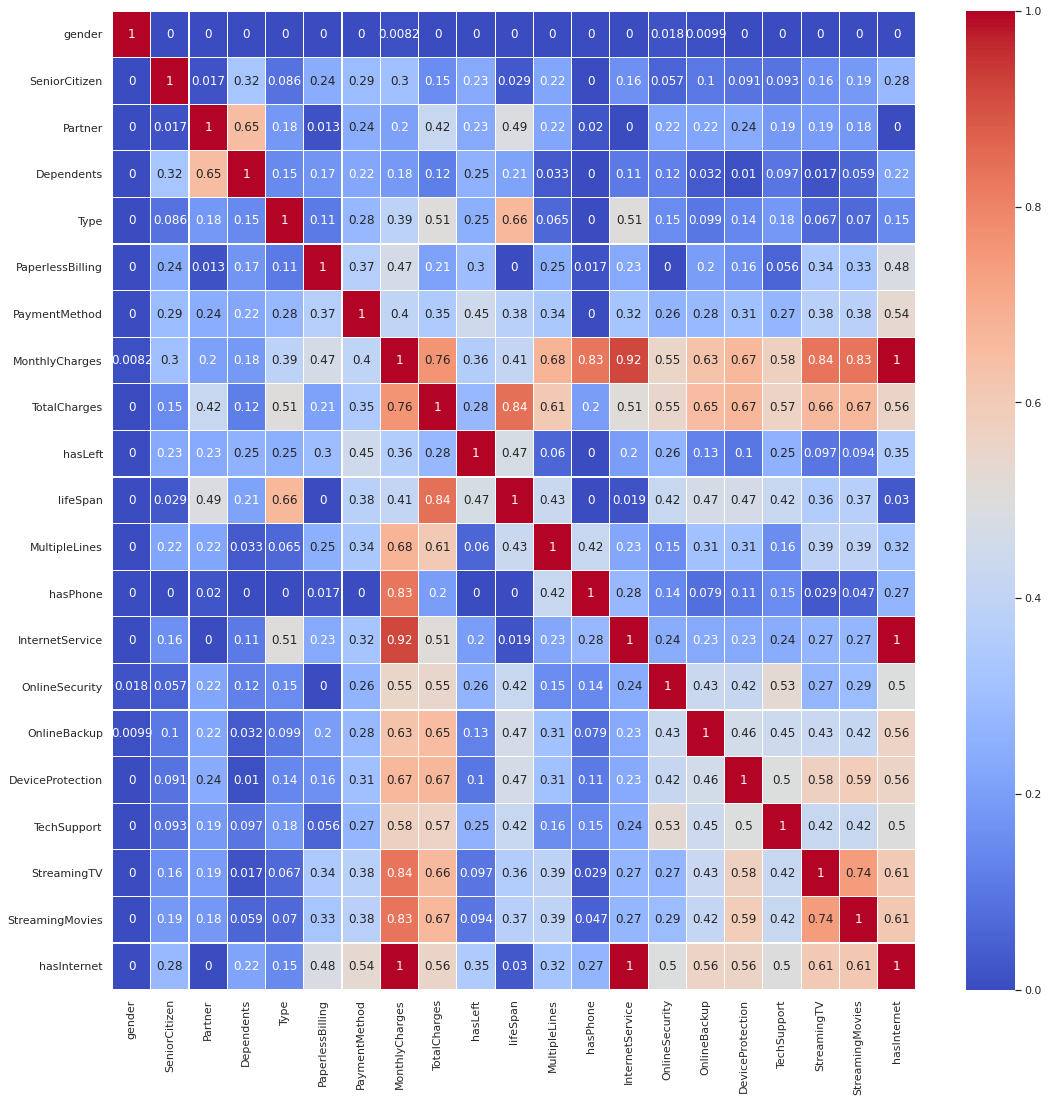

In [103]:
fig, ax = plt.subplots(figsize=(18, 18))

ax = sns.heatmap(phik_overview.values, annot=True,linewidths=0.1, xticklabels=column_names, yticklabels=column_names, cmap='coolwarm')

#ax.tick_params(length=0)
#ax.xaxis.tick_top() # x axis on top
#ax.xaxis.set_label_position('top')
#plt.show()

Очевидно, что две денежные колонки сильно коррелируют с параметрами интернета и телефонии.

Также стоит учитывать, что они представляют собой множественные дискретные значения, что может усложнить задачу классификации.

Эти две колонки придётся удалить из модели.

Выводы:
* Финансовые показатели сильно коррелируют с деталями услуг телефонии и интернета. Их необходимо удалить.
* Фактор gender практически не имеет взаимосвязей, в т.ч. с целевым признаком. Его также необходимо удалить.
* Коэффициент PhiK не показывает направление корреляции, направление по сильным взаимосявзям необходимо вычислять дополнительно.
* Следует изучить следующие пары признаков:
    * LifeSpan - Type (PhiK 0.66)
    * LifeSpan - Partner (PhiK 0.49)
    * Partner - Dependants (PhiK 0.66)
    * InternetService - Type (PhiK 0.51)

### 2.5 Оценка степени вклада факторов в целевой признак

Оценим факторы по степени их "важности" тремя способами.

Забегая вперёд можно сказать, что ни один из автоматических режимов оптимизации факторов не позволил достигнуть целевых показателей проекта.

In [104]:
target_f = df_oe_full['hasLeft']
features_f = df_oe_full.drop(['hasLeft','hasPhone','hasInternet'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(features_f, target_f, random_state=RANDOM_STATE)

features_columns = features_f.columns

Оценим вклад факторов в целевой признак с помощью Feature Importance

In [105]:
# feature extraction
model = ExtraTreesClassifier(n_estimators=100)
model.fit(features_f, target_f)

model_importance = model.feature_importances_
#print(model_importance)

df_importance = pd.DataFrame({'feature':features_columns, 'importance':model_importance})
display(df_importance.sort_values('importance', axis=0, ascending=False))

,feature,importance
9,lifeSpan,0.186
8,TotalCharges,0.142
7,MonthlyCharges,0.140
4,Type,0.092
6,PaymentMethod,0.062
11,InternetService,0.051
0,gender,0.037
5,PaperlessBilling,0.031
2,Partner,0.030
13,OnlineBackup,0.028


Оценим вклад факторов вторым способом: Univariate Selection

Версия SKLEARN в тренажёре старая и не поддерживает такой подход.
Закомментировал код оценки вторым способом

     ---------------------------------------------------------------------------
     AttributeError                            Traceback (most recent call last)
     /tmp/ipykernel_64/3169378059.py in <module>
           3 fit = test.fit(features_f, target_f)
           4 # summarize scores
     ----> 5 print(fit.feature_names_in_)
           6 print(fit.scores_)
           7 features_best = fit.transform(features_f)
    
     AttributeError: 'SelectKBest' object has no attribute 'feature_names_in_'

Рекурсивное удаление факторов. Эта часть закомментирована, т.к. занимает значительнео вермя при выполнении.

Удалим технические и второстепенные факторы из датасета

In [106]:
features_to_drop = [
    'gender', 'Dependents',
    'SeniorCitizen',
    'hasInternet', 'StreamingTV', # 'StreamingMovies',
    'Type',
    'hasPhone', 'MultipleLines',
    'MonthlyCharges', 'TotalCharges'
]

# удаляем факторы для кодирвоания, если принято решение их не использовать в модели
factors_to_encode_ohe = [x for x in factors_to_encode if x not in features_to_drop]
print(factors_to_encode_ohe)

['PaymentMethod', 'InternetService']


In [107]:
df_oe = df_oe_full.drop(features_to_drop, axis=1)

column_names_oe = df_oe.columns

Проведём OHE-кодирование факторов по сокращённому датасету

In [108]:
# кодирование One-Hot Encoding в режиме отбрасывания избыточного параметра
df_ohe = pd.get_dummies(
    df.drop(features_to_drop, axis=1),
    drop_first=True, columns=factors_to_encode_ohe
)

column_names_ohe = df_ohe.columns

display(df_ohe.sample(10))

,Partner,PaperlessBilling,hasLeft,lifeSpan,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingMovies,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic,InternetService_None
4101,0,1,0,184,1,0,0,0,1,0,0,0,0,0
750,0,1,0,822,1,1,0,0,0,0,0,1,0,0
3109,0,1,0,1706,0,0,0,0,0,0,0,0,0,1
982,0,1,0,1187,1,0,0,0,0,0,1,0,0,0
1446,0,1,0,31,0,0,0,0,0,0,1,0,0,0
6712,1,0,0,853,0,0,1,0,0,0,1,0,1,0
5189,0,0,0,31,0,1,0,0,0,0,1,0,0,0
2916,0,1,0,1553,1,0,0,1,1,1,0,0,0,0
988,0,0,0,822,0,0,0,0,0,0,0,1,0,1
1129,0,1,0,1432,0,0,0,0,0,1,0,0,1,0


Рассчитаем коэффициенты корреляций по сокращённому набору факторов

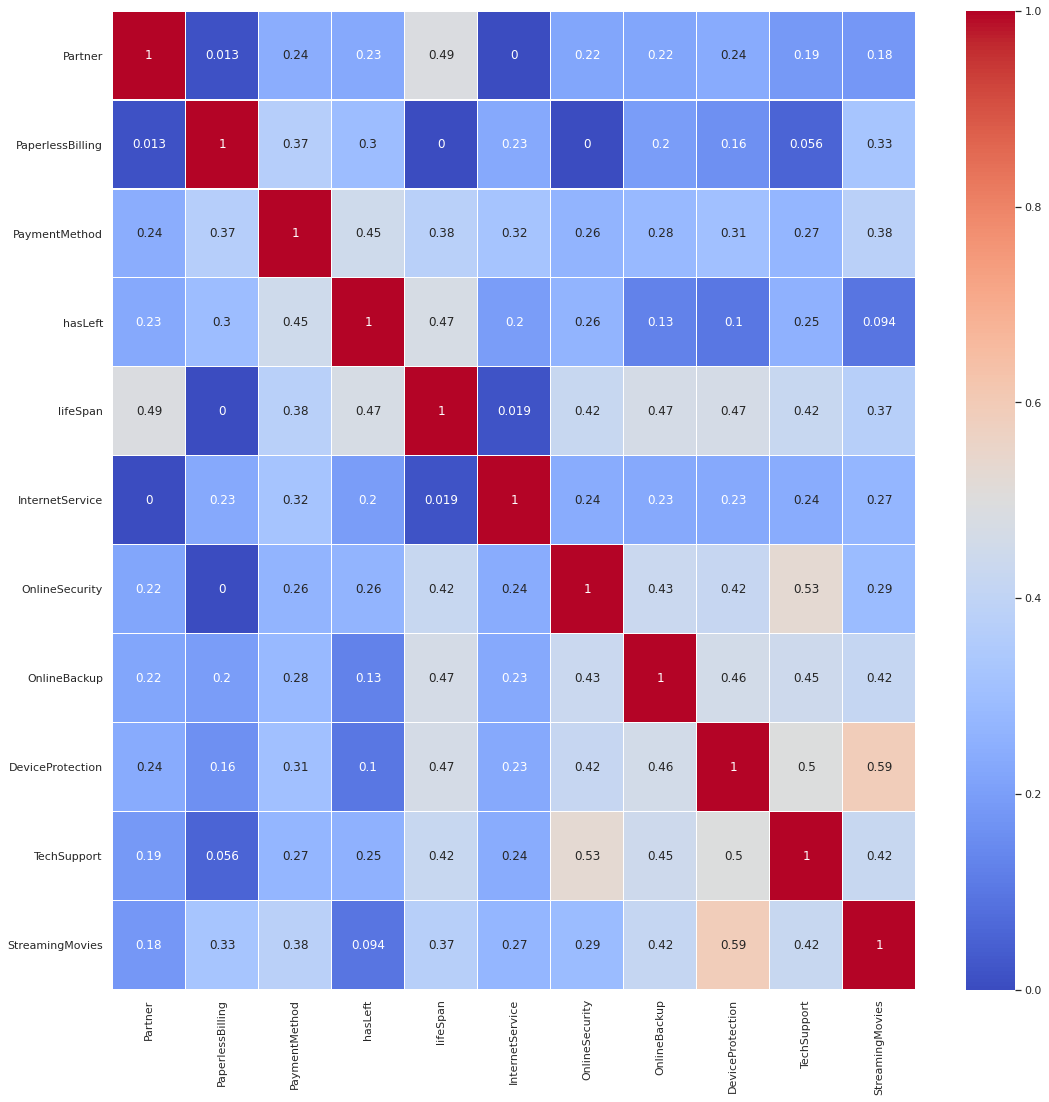

In [109]:
interval_cols = ['lifeSpan']
phik_overview = df_oe.phik_matrix(interval_cols=interval_cols)
phik_overview.round(2)

fig, ax = plt.subplots(figsize=(18, 18))
ax = sns.heatmap(phik_overview.values, annot=True,linewidths=0.1, xticklabels=column_names_oe, yticklabels=column_names_oe, cmap='coolwarm')

Подготовим тренировочную и тестовую выборки по данным OE

In [110]:
# Пропорции: 3:1 (75-25%)

target_oe = df_oe['hasLeft']
features_oe = df_oe.drop('hasLeft', axis=1)

features_columns_oe = features_oe.columns

#stratify=target_oe
features_train_oe, features_test_oe, target_train_oe, target_test_oe = train_test_split(features_oe, target_oe,
                                                                                    test_size=TEST_SAMPLE_RATIO, stratify=None, random_state=RANDOM_STATE)

print('Размер обучающей выборки OE:\t\t', features_train_oe.shape)
print('Размер тестовой выборки OE:\t\t', features_test_oe.shape)

print('\nБаланс классов обучающей выборки OE:\n', target_train_oe.value_counts(normalize=True))
print('\nБаланс классов тестовой выборки OE:\n', target_test_oe.value_counts(normalize=True))

Размер обучающей выборки OE:		 (5282, 10)
Размер тестовой выборки OE:		 (1761, 10)

Баланс классов обучающей выборки OE:
 0   0.735
1   0.265
Name: hasLeft, dtype: float64

Баланс классов тестовой выборки OE:
 0   0.734
1   0.266
Name: hasLeft, dtype: float64


Подготовим тренировочную и тестовую выборки по данным OHE

In [111]:
# Пропорции: 3:1 (75-25%)

target_ohe = df_ohe['hasLeft']
features_ohe = df_ohe.drop('hasLeft', axis=1)

features_columns_ohe = features_ohe.columns

#stratify=target_ohe
features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = train_test_split(features_ohe, target_ohe,
                                                                                    test_size=TEST_SAMPLE_RATIO, stratify=None, random_state=RANDOM_STATE)

print('Размер обучающей выборки OHE:\t\t', features_train_ohe.shape)
print('Размер тестовой выборки OHE:\t\t', features_test_ohe.shape)

print('\nБаланс классов обучающей выборки OHE:\n', target_train_ohe.value_counts(normalize=True))
print('\nБаланс классов тестовой выборки OHE:\n', target_test_ohe.value_counts(normalize=True))

Размер обучающей выборки OHE:		 (5282, 13)
Размер тестовой выборки OHE:		 (1761, 13)

Баланс классов обучающей выборки OHE:
 0   0.735
1   0.265
Name: hasLeft, dtype: float64

Баланс классов тестовой выборки OHE:
 0   0.734
1   0.266
Name: hasLeft, dtype: float64


## Выводы по шагу 2

<div class="alert alert-block alert-info">
</div>

* Типы данных преобразованы.
* Заполнены нулевым значением суммы общих затрат клиентов, зарегистрировавшихся в день выгрузки данных (11 вхождений).
* Таблицы объединены, проведена проверка корректности объединения.
* Проведено ранговое кодирование переменных.
* Баланс целевых классов смещён в соотношении примерно 70-30%. Необходимость перебалансировки не очевидна, сначала стоит пробовать исключение связанных между собой факторов и подбор гиперпараметров.
* Проведён визуальный и технический анализ распределения и вклада факторов в целевой признак. Из данных модели удалены факторы 'gender', 'Dependents', 'SeniorCitizen', 'hasInternet', 'StreamingTV', 'Type', 'hasPhone', 'MultipleLines', 'MonthlyCharges', 'TotalCharges'

## 3. Обучение моделей с выбором наилучших гиперпараметров

In [112]:
# функция оценки с помощью метрики ROC-AUC
def model_score(target, predictions):
    return roc_auc_score(target, predictions)

def model_score_ext(target, predictions):
    return roc_auc_score(target, predictions), accuracy_score(target, predictions)

# будем использовать штатный при CV скорер моделей
#scorer = make_scorer(model_score, greater_is_better=True)

In [113]:
result_key_columns = ['model']

model_results = pd.DataFrame({
    'model': [],
    'hyper_params': [],
    'metric':[]
})


# функция, добавляющая результаты в общую таблицу
def add_result(model_desc, hyper_params, metric):    
    model_results.loc[model_results.size] = [model_desc, hyper_params, metric]
    model_results.drop_duplicates(subset=result_key_columns, keep='last', inplace=True)

### 3.1 Dummy классификатор

In [114]:
#print(get_scorer_names())

scoring_dc = ["roc_auc", "accuracy", "balanced_accuracy"]

model_dc = DummyClassifier(strategy='prior')
cv_result = cross_validate(model_dc, features_train_oe, target_train_oe, scoring=scoring_dc)
#model.fit(features_train, target_train)
#predictions = pd.Series(model.predict(features_valid))
#score = model_score(target_valid, predictions)

add_result('DummyClassifier', "", cv_result['test_roc_auc'].mean())
display(model_results)

,model,hyper_params,metric
0,DummyClassifier,,0.500


### 3.2 Логистическая регрессия

In [115]:
# используем OHE-датасет
pipe_lr = Pipeline(
    [
        ('scale', StandardScaler()),
        #('reduce_dims', PCA(n_components=4)),
        ('LogisticRegression', LogisticRegression())
    ])

param_grid_lr = dict(
    #reduce_dims__n_components = [4,6,8],
    LogisticRegression__solver = ['liblinear'],
    LogisticRegression__C = np.linspace(0.0001, 100, 20)
)

#grid_lr = RandomizedSearchCV(pipe_lr, param_grid_lr, scoring=scorer, cv=5, verbose=0, n_jobs=-1, n_iter=3)
grid_lr = RandomizedSearchCV(pipe_lr, param_grid_lr, scoring='roc_auc', cv=5, verbose=0, n_jobs=-1)
grid_lr.fit(features_ohe, target_ohe)

add_result('LogisticRegression', str(grid_lr.best_params_), grid_lr.best_score_)
display(model_results)

,model,hyper_params,metric
0,DummyClassifier,,0.500
3,LogisticRegression,"{'LogisticRegression__solver': 'liblinear', 'LogisticRegression__C': 57.89477894736842}",0.835


### 3.3 Случайный лес

In [116]:
pipe_rf = Pipeline(
    [
        #('scale', StandardScaler()),
        #('reduce_dims', PCA(n_components=4)),
        ('RandomForestClassifier', RandomForestClassifier(random_state=RANDOM_STATE))
    ])

param_grid_rf = dict(
    #reduce_dims__n_components = [4,6,8,10,12],
    RandomForestClassifier__n_estimators = range(30, 151, 10),
    RandomForestClassifier__max_depth = range(1,15),
    RandomForestClassifier__min_samples_split = range(2,7)
)

#grid_rf = RandomizedSearchCV(model_rf, params_rf, scoring=scorer, cv=pds, verbose=0, n_jobs=-1)
grid_rf = RandomizedSearchCV(pipe_rf, param_grid_rf, scoring='roc_auc', cv=5, verbose=0, n_jobs=-1)
grid_rf.fit(features_oe, target_oe)

add_result('RandomForestClassifier', str(grid_rf.best_params_), grid_rf.best_score_)
display(model_results)

,model,hyper_params,metric
0,DummyClassifier,,0.500
3,LogisticRegression,"{'LogisticRegression__solver': 'liblinear', 'LogisticRegression__C': 57.89477894736842}",0.835
6,RandomForestClassifier,"{'RandomForestClassifier__n_estimators': 60, 'RandomForestClassifier__min_samples_split': 5, 'RandomForestClassifier__max_depth': 7}",0.853


In [117]:
#display(grid_rf.best_estimator_['reduce_dims'].components_)
#display(grid_rf.best_estimator_['RandomForestClassifier'].feature_importances_)

### 3.4 Градиентный бустинг с помощью LightGBM

In [118]:
pipe_gbm = Pipeline(
    [
        #('scale', StandardScaler()),
        #('reduce_dims', PCA(n_components=4)),
        ('LGBMClassifier', LGBMClassifier(random_state=RANDOM_STATE))
    ])

param_grid_gbm = dict(
    #reduce_dims__n_components = [4,6,8],
    LGBMClassifier__n_estimators = [50, 100, 500],
    #LGBMClassifier__num_leaves = [21, 31, 41, 51], 
    LGBMClassifier__num_leaves = [7], 
    LGBMClassifier__learning_rate = [0.01, .04, 0.06, 0.3]
)


grid_gbm = RandomizedSearchCV(pipe_gbm, param_grid_gbm, cv=5, verbose=0, scoring='roc_auc')
grid_gbm.fit(features_oe, target_oe)


add_result('LGBMClassifier', str(grid_gbm.best_params_), grid_gbm.best_score_)
display(model_results)

,model,hyper_params,metric
0,DummyClassifier,,0.500
3,LogisticRegression,"{'LogisticRegression__solver': 'liblinear', 'LogisticRegression__C': 57.89477894736842}",0.835
6,RandomForestClassifier,"{'RandomForestClassifier__n_estimators': 60, 'RandomForestClassifier__min_samples_split': 5, 'RandomForestClassifier__max_depth': 7}",0.853
9,LGBMClassifier,"{'LGBMClassifier__num_leaves': 7, 'LGBMClassifier__n_estimators': 500, 'LGBMClassifier__learning_rate': 0.3}",0.930


### 3.5 Градиентный бустинг с помощью LightGBM+Optuna

In [119]:
gbmo = LGBMClassifier(random_state=RANDOM_STATE)


param_grid_gbmo = dict(
    learning_rate=optuna.distributions.LogUniformDistribution(1e-4, 1),
    n_estimators=optuna.distributions.IntUniformDistribution(50,500),
    num_leaves=optuna.distributions.IntUniformDistribution(7,7)
)


optuna_gbmo = optuna.integration.OptunaSearchCV(gbmo, param_grid_gbmo, scoring='roc_auc', cv=5, n_trials=50, verbose=0) #, verbose=0, n_iter=10
optuna_gbmo.fit(features_oe, target_oe) #, verbose=0


add_result('LGBMClassifier+Optuna', str(optuna_gbmo.best_params_), optuna_gbmo.best_score_)
display(model_results)

/tmp/ipykernel_64/3632021279.py:5: FutureWarning: LogUniformDistribution has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :class:`~optuna.distributions.FloatDistribution` instead.
  learning_rate=optuna.distributions.LogUniformDistribution(1e-4, 1),
/tmp/ipykernel_64/3632021279.py:6: FutureWarning: IntUniformDistribution has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :class:`~optuna.distributions.IntDistribution` instead.
  n_estimators=optuna.distributions.IntUniformDistribution(50,500),
/tmp/ipykernel_64/3632021279.py:7: FutureWarning: IntUniformDistribution has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :class:`~optuna.distributions.IntDistribution` instead.
  num_leaves=optuna.distributions.IntUniformDistribution(7,7)
/tmp/ipykern

,model,hyper_params,metric
0,DummyClassifier,,0.500
3,LogisticRegression,"{'LogisticRegression__solver': 'liblinear', 'LogisticRegression__C': 57.89477894736842}",0.835
6,RandomForestClassifier,"{'RandomForestClassifier__n_estimators': 60, 'RandomForestClassifier__min_samples_split': 5, 'RandomForestClassifier__max_depth': 7}",0.853
9,LGBMClassifier,"{'LGBMClassifier__num_leaves': 7, 'LGBMClassifier__n_estimators': 500, 'LGBMClassifier__learning_rate': 0.3}",0.930
12,LGBMClassifier+Optuna,"{'learning_rate': 0.28774414947466814, 'n_estimators': 273, 'num_leaves': 7}",0.935


### 3.6 Градиентный бустинг с помощью CatBoost

In [120]:
pipe_cbc = Pipeline(
    [
        #('scale', StandardScaler()),
        #('reduce_dims', PCA(n_components=4)),
        ('CatBoostClassifier', CatBoostClassifier(verbose=0, random_state=RANDOM_STATE))
    ])

param_grid_cbc = dict(
    #reduce_dims__n_components = [4,6,8,10,12],
    CatBoostClassifier__learning_rate = [0.01, .04, 0.06, 0.3, 0.5],
    CatBoostClassifier__iterations = [150, 500, 1000]
)


grid_cbc = RandomizedSearchCV(pipe_cbc, param_grid_cbc, scoring='roc_auc', cv=5) #, verbose=0, n_iter=10
grid_cbc.fit(features_oe, target_oe)


add_result('CatBoostClassifier', str(grid_cbc.best_params_), grid_cbc.best_score_)
display(model_results)

,model,hyper_params,metric
0,DummyClassifier,,0.500
3,LogisticRegression,"{'LogisticRegression__solver': 'liblinear', 'LogisticRegression__C': 57.89477894736842}",0.835
6,RandomForestClassifier,"{'RandomForestClassifier__n_estimators': 60, 'RandomForestClassifier__min_samples_split': 5, 'RandomForestClassifier__max_depth': 7}",0.853
9,LGBMClassifier,"{'LGBMClassifier__num_leaves': 7, 'LGBMClassifier__n_estimators': 500, 'LGBMClassifier__learning_rate': 0.3}",0.930
12,LGBMClassifier+Optuna,"{'learning_rate': 0.28774414947466814, 'n_estimators': 273, 'num_leaves': 7}",0.935
15,CatBoostClassifier,"{'CatBoostClassifier__learning_rate': 0.06, 'CatBoostClassifier__iterations': 1000}",0.938


In [121]:
#display(grid_cbc.best_estimator_['reduce_dims'].components_)
importance_cbc = grid_cbc.best_estimator_['CatBoostClassifier'].feature_importances_

#print(features_columns)
#display(importance_cbc)

df_importance_cbc = pd.DataFrame({'feature':features_columns_oe, 'importance':importance_cbc})
display(df_importance_cbc.sort_values('importance', axis=0, ascending=False))

,feature,importance
3,lifeSpan,68.982
4,InternetService,11.733
2,PaymentMethod,6.159
9,StreamingMovies,2.239
1,PaperlessBilling,2.114
8,TechSupport,2.031
5,OnlineSecurity,1.901
6,OnlineBackup,1.838
0,Partner,1.793
7,DeviceProtection,1.209


### 3.7 Градиентный бустинг с помощью CatBoost+Optuna

In [122]:
cbco = CatBoostClassifier(verbose=0, random_state=RANDOM_STATE)


param_grid_cbco = dict(
    learning_rate=optuna.distributions.LogUniformDistribution(1e-4, 1),
    min_data_in_leaf=optuna.distributions.IntUniformDistribution(1,10),
    iterations=optuna.distributions.IntUniformDistribution(800,1200,100),
    subsample=optuna.distributions.UniformDistribution(0.7,0.9)
)


optuna_cbco = optuna.integration.OptunaSearchCV(cbco, param_grid_cbco, scoring='roc_auc', cv=5, n_trials=50, verbose=0) #, verbose=0, n_iter=10
optuna_cbco.fit(features_oe, target_oe) #, verbose=0


add_result('CatBoostClassifier+Optuna', str(optuna_cbco.best_params_), optuna_cbco.best_score_)
display(model_results)

/tmp/ipykernel_64/2191432601.py:5: FutureWarning: LogUniformDistribution has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :class:`~optuna.distributions.FloatDistribution` instead.
  learning_rate=optuna.distributions.LogUniformDistribution(1e-4, 1),
/tmp/ipykernel_64/2191432601.py:6: FutureWarning: IntUniformDistribution has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :class:`~optuna.distributions.IntDistribution` instead.
  min_data_in_leaf=optuna.distributions.IntUniformDistribution(1,10),
/tmp/ipykernel_64/2191432601.py:7: FutureWarning: IntUniformDistribution has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :class:`~optuna.distributions.IntDistribution` instead.
  iterations=optuna.distributions.IntUniformDistribution(800,1200,100),


,model,hyper_params,metric
0,DummyClassifier,,0.500
3,LogisticRegression,"{'LogisticRegression__solver': 'liblinear', 'LogisticRegression__C': 57.89477894736842}",0.835
6,RandomForestClassifier,"{'RandomForestClassifier__n_estimators': 60, 'RandomForestClassifier__min_samples_split': 5, 'RandomForestClassifier__max_depth': 7}",0.853
9,LGBMClassifier,"{'LGBMClassifier__num_leaves': 7, 'LGBMClassifier__n_estimators': 500, 'LGBMClassifier__learning_rate': 0.3}",0.930
12,LGBMClassifier+Optuna,"{'learning_rate': 0.28774414947466814, 'n_estimators': 273, 'num_leaves': 7}",0.935
15,CatBoostClassifier,"{'CatBoostClassifier__learning_rate': 0.06, 'CatBoostClassifier__iterations': 1000}",0.938
18,CatBoostClassifier+Optuna,"{'learning_rate': 0.07506653623107429, 'min_data_in_leaf': 6, 'iterations': 800, 'subsample': 0.8918829866087334}",0.939


Оценим вклад параметров в результат моделирования

In [123]:
#display(grid_cbc.best_estimator_['reduce_dims'].components_)
importance_cbco = optuna_cbco.best_estimator_.feature_importances_

#print(features_columns_oe)
#display(importance_cbco)

df_importance_cbco = pd.DataFrame({'feature':features_columns_oe, 'importance':importance_cbco})
display(df_importance_cbco.sort_values('importance', axis=0, ascending=False))

,feature,importance
3,lifeSpan,69.152
4,InternetService,12.091
2,PaymentMethod,5.942
1,PaperlessBilling,2.329
9,StreamingMovies,2.078
8,TechSupport,1.992
5,OnlineSecurity,1.909
0,Partner,1.702
6,OnlineBackup,1.637
7,DeviceProtection,1.168


## Выводы по шагу 3

<div class="alert alert-block alert-info">
</div>

* Проведена проверка адекватности моделей. Все модели адекватны.
* Обучены модели логистической регрессии, случайного леса, LightGBM и CatBoost.
* Наилучший результат показала модель CatBoost с помощью оптимизатора Optuna:
    * Параметры: {'learning_rate': 0.07506653623107429, 'min_data_in_leaf': 6, 'iterations': 800, 'subsample': 0.8918829866087334}
    * Метрика ROC-AUC на обучающей выборке с кросс-валидацией: 0.939
    
Модель CatBoost+Optuna имеет наилучший показатель целевой метрики и выбирается для промышленной эксплуатации.

## 4. Тестирование выбранной модели

В данном разделе протестируем выбранную модель с позиций клиента на тестовой выборке.
Также построим графики метрик качества модели и определим дальнейшие перспективы её улучшения.

In [124]:
# оценка показателей качества модели
def evaluate_model_quality(model, features, target):
    predicted = model.predict(features)
    
    accuracy = accuracy_score(target, predicted)    
    recall = recall_score(target, predicted)    
    precision = precision_score(target, predicted)    
    f1_value = f1_score(target, predicted)
    auc_roc_value = roc_auc_score(target, model.predict_proba(features)[:, 1])
    #auc_roc_value = roc_auc_score(target, predicted)
    cm = confusion_matrix(target, predicted)
    
    return accuracy, recall, precision, f1_value, auc_roc_value, cm

In [125]:
# Функция вывода кривой ROC
def print_roc_distribution(model, features, target, axe):
    
    probabilities_valid = model.predict_proba(features)
    probabilities_one_valid = probabilities_valid[:, 1]
    fpr, tpr, thresholds = roc_curve(target, probabilities_one_valid) 
        
    #plt.figure(figsize=(10,7))
    plt.axes(axe)

    plt.plot(fpr, tpr, linestyle='solid')

    plt.plot([0, 1], [0, 1], linestyle='dotted')

    plt.xlim([0, 1])
    plt.ylim([0, 1])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.title('ROC-кривая')
    
    #plt.show()
    #sns.set()

In [126]:
# Функция вывода матрицы ошибок
def print_confusion_matrix(cm, axe):    
    #plt.figure(figsize=(10,7))
    axe.set_title('Матрица ошибок')
    s = sns.heatmap(cm, annot=True, fmt='d', cmap= 'Spectral_r', linewidths=3, linecolor='white', ax=axe) #RdYlBu_r
    s.set(xlabel='Предсказания', ylabel='Ответы')
        
    #plt.xlabel('Предсказания')
    #plt.ylabel('Ответы')
    #plt.title('Матрица ошибок')
    
    #plt.show()
    #sns.set()

In [127]:
# создадим функцию для вывода всех метрик
def describe_model(model_desc, hyper_params, model, features, target):
     
    #predicted = model.predict(features)
    accuracy, recall, precision, f1, auc_roc, cm = evaluate_model_quality(model, features, target)
    
    print('Параметры модели', model_desc, '('+hyper_params+')','\n')
    print('Accuracy:\t', accuracy)
    print('Полнота:\t', recall)
    print('Точность:\t', precision)
    print('F1-метрика:\t', f1)
    print('AUC-ROC-метрика:', auc_roc)
    print()

    fig, axes = plt.subplots(1,2, figsize=(18, 7))
    
    print_roc_distribution(model, features, target, axes[0])
    print_confusion_matrix(cm, axes[1])
    
    plt.show()
    sns.set()

In [128]:
# функция оценки метрик качества и производительности модели
def calculate_model_performance(model, features_train, target_train, features_test, target_test):
    
    start_time_fit = time.time()
    model.fit(features_train, target_train)
    stop_time_fit = time.time()
    
    fit_time = stop_time_fit - start_time_fit
    
    start_time_predict = time.time()
    predictions = model.predict(features_test)
    stop_time_predict = time.time()
    
    predict_time = stop_time_predict - start_time_predict
    
    metric, accuracy = model_score_ext(target_test, predictions)
    
    return metric, accuracy, fit_time, predict_time

In [129]:
model_performance = pd.DataFrame({
    'model': [],
    'hyper_params': [],
    'metric':[],
    'accuracy':[],
    'fit_time': [],
    'predict_time': [],
    'total_time': []
})


# функция, добавляющая результаты в общую таблицу
def get_performance(model_desc, hyper_params, model, features_train, target_train, features_test, target_test):
    metric, accuracy, fit_time, predict_time = calculate_model_performance(model,
                                                               features_train, target_train, features_test, target_test)
    describe_model(model_desc, hyper_params, model, features_test, target_test)
    total_time = fit_time + predict_time
    model_performance.loc[model_performance.size] = [model_desc, hyper_params, metric, accuracy, fit_time, predict_time, total_time]
    model_performance.drop_duplicates(subset=result_key_columns, keep='last', inplace=True)

CatBoost + Optuna

Параметры модели CatBoostClassifier+Optuna ({'learning_rate': 0.07506653623107429, 'min_data_in_leaf': 6, 'iterations': 800, 'subsample': 0.8918829866087334}) 

Accuracy:	 0.9102782509937536
Полнота:	 0.7628205128205128
Точность:	 0.8836633663366337
F1-метрика:	 0.8188073394495412
AUC-ROC-метрика: 0.9407038887897357



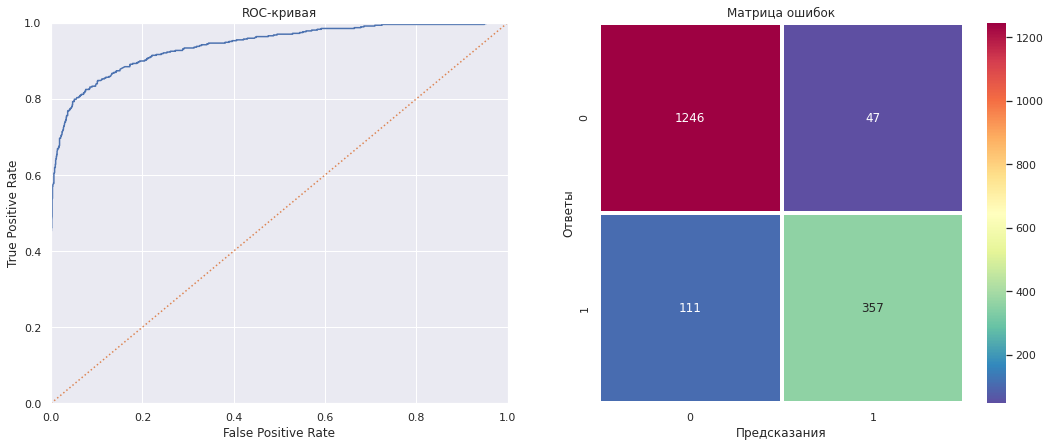

,model,hyper_params,metric,accuracy,fit_time,predict_time,total_time
0,CatBoostClassifier+Optuna,"{'learning_rate': 0.07506653623107429, 'min_data_in_leaf': 6, 'iterations': 800, 'subsample': 0.8918829866087334}",0.863,0.910,2.459,0.003,2.462


In [130]:
model = optuna_cbco.best_estimator_

params = str(optuna_cbco.best_params_)
model_name = 'CatBoostClassifier+Optuna'

get_performance(model_name, params, model, features_train_oe, target_train_oe, features_test_oe, target_test_oe)
display(model_performance)

## Выводы по шагу 4

<div class="alert alert-block alert-info">
</div>

* Лучшая модель, обученная на предыдущем шаге, протестирована на тестовой выборке.
* Наилучший результат даёт модель градиентного бустинга CatBoost с параметрами {'learning_rate': 0.07506653623107429, 'min_data_in_leaf': 6, 'iterations': 800, 'subsample': 0.8918829866087334}	

Ключевые метрики проекта
* AUC-ROC: 0.940
* Accuracy: 0.910

Заданная цель проекта достингута.

## Что дальше?

Несмотря на выполнение условия проекта, модель демонстрирует признаки переобучнеия и имеет потенциал для дальнейшего улучшения.

Возможные шаги дальнейшей оптимизации модели:
* Проверить статистичекие гипотезы о различии распределений факторов в сравнении общего массива клиентов с ушедшими.
* Проанализировать выявленные различающиеся распределения.
* Оценить взаимосвязи между "важными" факторами
* Проанализировать временные характеристики параметров. Например: цикличность ежемесячных расходов.

На основании полученных выводов можно будет принять решение о включении тех или иных факторов в модель.

## Общий вывод

<div class="alert alert-block alert-info">
</div>

* Данные успешно загружены.
* Пропусков, дубликатов, очевидных искажений и выбросов в данных не наблюдается.
* Целевые классы получены из поля contract.EndDate по принципу заполнения/незаполнения даты закрытия контракта.
* Рассчитан "срок жизни" клиента как функция даты начала и даты завершения контракта


* Таблицы объединены, проведена проверка корректности объединения.
* Проведено ранговое кодирование переменных.
* Баланс целевых классов смещён в соотношении примерно 70-30%. Перебалансировка не потребовалась.
* Проведён визуальный и технический анализ распределения и вклада факторов в целевой признак. Из данных модели удалены факторы 'gender', 'Dependents', 'SeniorCitizen', 'hasInternet', 'StreamingTV', 'Type', 'hasPhone', 'MultipleLines', 'MonthlyCharges', 'TotalCharges'


* Обучены модели логистической регрессии, случайного леса, LightGBM и CatBoost. Все модели адекватны.
* Наилучший результат показала модель CatBoost с помощью оптимизатора Optuna:
    * Параметры: {'learning_rate': 0.07506653623107429, 'min_data_in_leaf': 6, 'iterations': 800, 'subsample': 0.8918829866087334}
    * Метрика ROC-AUC на обучающей выборке с кросс-валидацией: 0.939
    * Метрика ROC-AUC на тестовой выборке с кросс-валидацией: 0.940
    * Accuracy на тестовой выборке: 0.910

Полученные параметры позволяют считать проект успешно завершённым.

## Отчёт по проделанной работе

В отчёте необходимо ответить на вопросы:
* Какие пункты плана были выполнены, а какие — нет (поясните почему)?
* Какие трудности возникли и как вы их преодолели?
* Какие ключевые шаги в решении задачи выделили?
* Какая ваша итоговая модель и какое у неё качество?

Дополнительные фокусы контроля:
* Ответили на все вопросы или нет?
* Понятны ли ответы на вопросы?

Данный проект выполнялся в интересах компании-оператора связи.

Озвученная заказчиком бизнес-цель проекта - повышение лояльности и снижение оттока клиентов.

Технической целью является создание модели, способной с заданными метриками качества предсказывать намерение клиента в ближайшее время прекратить сотрудничество с компанией.

Основная метрика качества: AUC-ROC, дополняющая - Accuracy, то есть процент точности предсказаний модели.

Данные предоставлены технической командой оператора, содержат персональные данные о некоторых клиентах, а также информацию об их тарифах и договорах.

Далее по пунктам плана опишем шаги проекта.

### Ключевые шаги проекта

Проект является типичной задачей бинарной классификации, поэтому основные шаги были выбраны соответсвующие.

#### Шаг1: Загрузка и предварительный анализ данных

Команда заказчика предоставила качественные данные, что подтвердил стандартный инструментарий контроля данных:

* Формат и структура предоставленных данных позволили продолижть работу над проектом без дополнительных уточнений.
* В данных отсутствовали пропуски, выбросы, явные или скрытые дубли и иные виды очевидных искажений. Единственным исключением являются пустые (NULL) значения суммы месячной оплаты у 11 клиентов, зарегистрировавшихся в день выгрузки данных.
* Наблюдались несущественные разночтения в формате представления логических показателей: где-то они кодировались числом (0/1), а где-то - строкой (Yes/No).
* Также выявлено различие в выгрузке дат: BeginDate содержит только дату, в то время как EndDate содержит время, а также строковые значения 'No'.

Данные факты не помешали работе и были переданы команде заказчика в качестве "наблюдения" и рекомендаций.
    

#### Шаг 2: Предобработка и ислледовательский анализ данных

##### Предобработка
Так как не все клиенты используют обе услуги оператора (телефонию и Интернет), при объединении таблиц закономерно возникают пропуски. Добавлены булевы признаки hasPhone, hasInternet для однозначной классификации исходных данных в анализе.

Также преобразованы типы данных даты начала и окончания, суммы общих затрат с обработкой пропусков и нетипичных значений.

Целевой признак заказчиком явно предоставлен не был, поэтому его создавали из факта покидания клиентом компании: у ушедшего клиента указана дата завершения.

Так как даты начала и окончания являются абсолютными значениями и не могут быть факторами модели, на их основании создан признак «Срок жизни клиента» (lifeSpan). Он рассчитывается как разность между датой окончания контракта и датой регистрации пользователя. Если клиент продолжает пользоваться услугами, расчёт идёт от даты выгрузки данных.

Данные шаги позволили подойти к объединению таблиц в общую таблицу.

После объединения:
* Все логические факторы были преобразованы в числовое 0/1. 
* Проведён анализ пропусков: 11 клиентов действительно зарегистрировались в день выгрузки, и это все клиенты, зарегистрировавшиеся в день выгрузки. В случае дальнейшего развития модели новых клиентов можно сегментировать и отсекать: очевидно, что в первое время клиентам требуется не удержание, а корректное «приземление». Пока же таким выявленным клиентам установили нулевые суммы платежей.

##### Проверка сбалансированности классов. 

Баланс классов в предоставленных данных смещён в соотношении примерно 70-30%.

С учётом того, что это реальные данные и уходящих клиентов должно быть по определению меньше, чем остающихся, сначала стоит попробовать оптимизации моделей без ребаланса: через исключение связанных между собой факторов и подбор гиперпараметров.

##### Исследовательский анализ

Мужчин и женщин в выборке примерно поровну, та же ситуация с людьми одинокими и имеющими партнёра. Треть клиентов имеет иждивенцев, примерно 18% пользователей - пенсионеры.
* Ушедших мужчин и женщин поровну, данный фактор можно не использовать в модели.
* Пенсионеры уходят чаще, но их немного.
* Люди, не имеющие пратнёра, уходят чаще.
* Люди, не имеющие иждивенцев, уходят чаще.

Чуть более половины пользователей предпочитает ежемесячную оплату, остальные поровну делятся на покупателей двухлетних и трёхлетних тарифных планов.
* При этом половина пользователей с помесячной оплатой ушла. Это выглядит как одна из "категорий риска" ухода.
60% клиентов используют элеткронные счета.
* Клиентов с бумажными счетами ушло примерно в два раза меньше.
22% клиентов платят физическими чеками. Остальные предпочитают электронные средства платежа.
* Примерно половина из плательщиков электронным чеком ушла. Это выглядит как одна из "категорий риска" ухода.

В ежемесячных списаниях наблюдается существенный процент малых платежей (в пределах $20).

Также есть пики на 50, 60, 70, 80, 90 и 100 долларах. Вероятно, они увязаны с тарифными планами или пакетными предложениями.
* Уходят преимущественно клиенты с высоким ежемесячным чеком (от \$70), порядка трети от клиентов с высоким чеком.
* Средний месячный чек ушедших выше примерно на \$10
* Клиенты с высоким чеком уходят чаще, если смотреть в пропорции по сумме. И их явно выгодней удерживать и привлекать акциями.
* С низкими тарифами у провайдера всё выглядит нормально.

Дальнейшим развитием анализа может быть сплит на уровне \$70, потому что это похоже минимум на два разных сегмента клиентов. Или кластеризация без учителя: посмотреть, в какие группы модель распределит клиентов.

Сумма общих затрат клиентов выглядит закономерно для накапливающегося значения.
* что касается ушедких клиентов - они тратят более чем в два раза меньше денег по сравнению с обычными. По графику можно предположить, что это относительно новые клиенты, использующие много услуг и неприятно удивляющиеся счетам или недовольные качеством.
* Свыше $5600 начинаются редкие значения уходов: долгосрочные клиенты остаются верны компании.

Срок жизни клиентов:
* График подтверждает ситуацию: много клиентов уходит сразу.
* В среднем, половина ушедших клиентов разорвала контракт через год.
* Ещё четверть клиентов ушла в срок от года до трёх лет.

*Использование телефонии*

Телефон есть у большинства клиентов. Скорее всего потому, что оператор начинал с телефонии и DSL-интернета.
Пользователи одной и нескольких телефонных линий делятся примерно поровну, ушедшие - тоже. Данный признак, сокрее всего, не будет полезен в модели.

*Использование интернета*

* Чаще уходят пользователи, имеющие интернет.
* Ушедшие пользователи чаще использовали оптическое подключение.
* Ушедшие чаще используют OnlineSecurity.
* Показатели резервного копирования и защиты устройств примерно одинаковы для ушедших и неушедших.
* Ушедшие чаще обращались в (расширенную?) техническую поддержку.
* Ушедшие чаще заказывали услуги просмотра телевидения или кинофильмов, при этом такие услуги интересны менее чем половине клиентов.
* Показатели StreamingTV и StreamingMovies выглядят идентично и сильно (0.74) коррелируют между собой. Скорее всего это пакетное предложение, и один из факторов можно безопасно удалить из модели.
* Так же идентично выглядят пары OnlineSecurity-TechSupport и OnlineBackup-DeviceProtection.

Текущие графики не отвечают на вопрос: а на что же ушедшие тратили свои повышенные чеки? На ТВ и кино, или более скоростные тарифы?

В силу сжатых временных рамок проекта, данные аналитические выкладки делались без применения статистических критериев на различия. На одной из последующих итераций улучшения модели возможно введение статистического инструментария.

##### Проверка вклада и взаимозависимостей факторов

Помимо аналитического подхода, необходимо провести техническую аналитику: оценить степень вклада факторов в модель. Очевидно, что часть факторов не относится к 
Построена марица взаимных корреляций с помощью критерия PhiK.

Выводы:
* Финансовые показатели сильно коррелируют с деталями услуг телефонии и интернета. Их необходимо удалить.
* Фактор gender практически не имеет взаимосвязей, в т.ч. с целевым признаком. Его также необходимо удалить.
* Коэффициент PhiK не показывает направление корреляции, направление по сильным взаимосявзям необходимо вычислять дополнительно.
* Следует изучить следующие пары признаков:
    * LifeSpan - Type (PhiK 0.66)
    * LifeSpan - Partner (PhiK 0.49)
    * Partner - Dependants (PhiK 0.66)
    * InternetService - Type (PhiK 0.51)

Очевидно, что две "денежные" колонки сильно коррелируют с детальными параметрами интернета и телефонии.

Также стоит учитывать, что они представляют собой множественные дискретные значения, что может усложнить задачу классификации.
Эти две колонки придётся удалить из модели в текущем проекте.

##### Оценка степени вклада факторов в целевой признак, подготовка данных для обучения

Оценка вклада факторов проведена с помощью трёх подходов: Feature Importance, Univariate Selection и Рекурсивное удаление факторов.
    
Комбинация подходов позволила удалить следующие факторы как несущественные:
* gender
* Dependents
* SeniorCitizen
* StreamingTV
* Type
* MultipleLines
* MonthlyCharges
* TotalCharges

Также удалены технические прищнаки hasInternet и hasPhone.

Проведено кодирование признаков (Ordinal и One-Hot – под разные модели), подготовлены тренировочная и тестовая выборки.

#### Шаг 3: Обучение моделей с выбором наилучших гиперпараметров
С помощью Dummy-модели проведена проверка адекватности остальных моделей. Все модели адекватны.
Обучены модели логистической регрессии, случайного леса, LightGBM и CatBoost.

Поиск гиперпараметров LightGBM и CatBoost проводился с помощью оптимизаторов RandomSearchCV и OptunaSearchCV.
Optuna отработала медленней, но показала существенный прирост качества моделей на выявленных гиперпараметрах.

Наилучший результат показала модель CatBoost с помощью оптимизатора Optuna:
* Параметры: {'learning_rate': 0.07506653623107429, 'min_data_in_leaf': 6, 'iterations': 800, 'subsample': 0.8918829866087334}
* Метрика ROC-AUC на обучающей выборке с кросс-валидацией: 0.939

Модель CatBoost+Optuna имеет наилучший показатель целевой метрики и выбирается для промышленной эксплуатации.

#### Шаг 4: Тестирование выбранной модели

На этом шаге проведён тест выбранной модели с позиций клиента на тестовой выборке.

Также построены графики метрик качества модели и определены дальнейшие перспективы её улучшения.

Ключевые метрики проекта на тестовых данных:
* AUC-ROC: 0.863
* Accuracy: 0.910

Заданная цель проекта достингута.

На основании пройденных шагов и полученных данных написан общий вывод.

В целом план работы удалось выдержать, существенных сложностей в работе над проектом не возникало.

#### Что дальше?

Несмотря на выполнение условия проекта, модель демонстрирует признаки переобучнеия и имеет потенциал для дальнейшего улучшения.

Перед промышленной эксплуатацией необходимо зафиксировать состояние кодировщиков категориальных переменных, чтобы модель сохраняла работоспособность при апоявлении в данных новых категорий.

Возможные шаги дальнейшей оптимизации модели:
* Проверить статистичекие гипотезы о различии распределений факторов в сравнении общего массива клиентов с ушедшими.
* Проанализировать выявленные различающиеся распределения.
* Оценить взаимосвязи между "важными" факторами
* Проанализировать временные характеристики параметров. Например: цикличность ежемесячных расходов.

На основании сформированных выводов можно будет принять решение о включении тех или иных факторов в обновлённую модель.